<h1><div align="center">Social Data Mining</div></h1>
<h2><div align="center">Lesson III - Wikipedia</div></h2>
<div align="center">Bruno Gonçalves</div>
<div align="center"><a href="http://www.data4sci.com/">www.data4sci.com</a></div>
<div align="center">@bgoncalves, @data4sci</div>

In [1]:
import sys
from collections import Counter
from pprint import pprint
import gzip


import numpy as np
import matplotlib.pyplot as plt 
from xml.parsers import expat

import watermark

%load_ext watermark
%matplotlib inline

Let's start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -p numpy,matplotlib,expat

Thu Sep 05 2019 

CPython 3.7.3
IPython 6.2.1

numpy 1.16.2
matplotlib 3.1.0
expat not installed

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


# Geo tags

In [3]:
header = {}
coordinates = []

line_count = 0

for line in gzip.open("data/enwiki-20170420-geo_tags.csv.gz", "rt"):
    fields = line.strip().split(',')

    if line_count == 0:
        header = dict(zip(fields, range(len(fields))))

    line_count += 1

    if(fields[header["gt_globe"]] == "earth"):
        coordinates.append([float(fields[header["gt_lat"]]), float(fields[header["gt_lon"]])])
    
coordinates = np.array(coordinates)

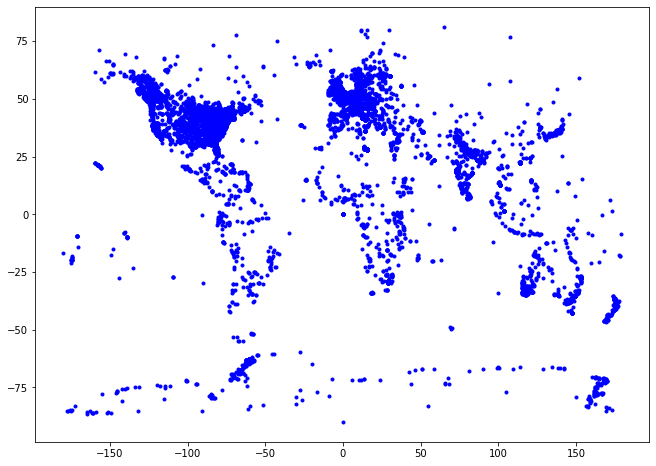

In [4]:
plt.plot(coordinates.T[1][:10000], coordinates.T[0][:10000], 'b.')
plt.gcf().set_size_inches(11,8)

# Language Links

In [5]:
header = {}
line_count = 0

ll_from = {}
for line in gzip.open("data/acewiki-20170420-langlinks.csv.gz", "rt"):
    fields = line.strip().split(',')

    if line_count == 0:
        header = dict(zip(fields, range(len(fields))))

    line_count += 1

    if fields[header["ll_lang"]] == "ab":
        key = fields[header["ll_title"]]

        ll_from[key] = fields[header["ll_from"]]

In [6]:
header = {}
line_count = 0

for line in gzip.open("data/abwiki-20170420-stub-meta-current.csv.gz", "rt"):
    fields = line.strip().split(',')

    if line_count == 0:
        header = dict(zip(fields, range(len(fields))))

    line_count += 1

    title = fields[header["title"]]

    if title in ll_from:
        print("ace", ll_from[title], "ab", fields[header["page_id"]])

ace 7343 ab 1037
ace 1293 ab 2106
ace 3511 ab 2245
ace 1292 ab 2305
ace 109 ab 2307
ace 200 ab 2320
ace 210 ab 2409
ace 495 ab 2903
ace 485 ab 2911
ace 898 ab 2947
ace 1449 ab 3002
ace 9238 ab 3291
ace 1259 ab 3293
ace 368 ab 3314
ace 1262 ab 3325
ace 2148 ab 3380
ace 198 ab 3406
ace 2243 ab 3482
ace 2242 ab 3500
ace 537 ab 3502
ace 39 ab 3526
ace 5101 ab 3529
ace 483 ab 3568
ace 482 ab 3577
ace 408 ab 3599
ace 1252 ab 3631
ace 4960 ab 3657
ace 409 ab 3682
ace 538 ab 3731
ace 3961 ab 3765
ace 407 ab 3783
ace 101 ab 3784
ace 1256 ab 3787
ace 510 ab 3797
ace 146 ab 3800
ace 508 ab 3872
ace 92 ab 3915
ace 504 ab 3930
ace 161 ab 3959
ace 98 ab 3960
ace 103 ab 3961
ace 6310 ab 4030
ace 3017 ab 4036
ace 2067 ab 4042
ace 1897 ab 4066
ace 488 ab 4133
ace 526 ab 4204
ace 60 ab 4209
ace 405 ab 4524
ace 3166 ab 4533
ace 744 ab 4596
ace 2467 ab 4603
ace 2578 ab 4607
ace 102 ab 4610
ace 2457 ab 4615
ace 49 ab 4636
ace 17 ab 4654
ace 3236 ab 4660
ace 418 ab 4687
ace 8703 ab 4770
ace 548 ab 4789
ace 

# Revisions

To process the revisions XML file, we must use expat to navigate through the XML tree. This implies overriding some functions to handle the start/end/contents of XML tags. We start by defining some useful variables

In [7]:
isContributor = False
isArticle = False
isPage = False
isData = False
buffer = u""
page_id = None
timestamp = None
revision_id = None
title = None

The fields we will be interested in are:


In [8]:
fields = set(["timestamp", "page", "id", "ns", "revision", "contributor", "title"])

The start element function is relatively simple. It just has to check that we are starting one of the elements we are interested in and, if so, set the proper flags accurately

In [9]:
def start_element(name, attrs):
    global buffer, isData, isPage, isContributor

    if name in fields:
        buffer = ""

        if name == "page":
            isPage = True
        elif name == "revision":
            isPage = False
        elif name == "contributor":
            isContributor = True
        else:
            isData = True
            buffer = ""

The end_element method is where all the hard work gets done. It must check in which state the system is (in which element we are in, exactly) and load the buffer data to the correct variables

In [10]:
def end_element(name):
    global buffer, isData, isPage, isArticle, isContributor, timestamp, page_id, revision_id, title

    if name in fields:
        if name == "ns":
            if int(buffer) == 0:
                isArticle = True
            else:
                isArticle = False
        elif name == "timestamp":
            timestamp = buffer
        elif name == "id":
            if isPage:
                page_id = buffer
                isPage = False
            elif not isContributor:
                revision_id = buffer
        elif name == "revision":
            if isArticle:
                print(",".join([page_id, revision_id, timestamp, title]))
        elif name == "page":
            isArticle = False
        elif name == "contributor":
            isContributor = False
        elif name == "title":
            title = buffer

    buffer = u""
    isData = False

Finally, the char_data function just adds the newly read data to the current buffer.

In [11]:
def char_data(data):
    global isData, buffer

    if isData:
        buffer += data

The history file we're going to use is:

In [12]:
meta_history_file = "data/acewiki-20170420-stub-meta-history.xml.gz"

To create a parser we simply instantiate one and override the correct methods

In [13]:
p = expat.ParserCreate()

p.StartElementHandler = start_element
p.EndElementHandler = end_element
p.CharacterDataHandler = char_data

Now we must simply give it a file handle to the file we wish to parse and hope for the best :)

In [14]:
print(",".join(["page_id", "revision_id", "timestamp", "title"]))

try:
    p.ParseFile(gzip.open(meta_history_file))
except Exception as e:
    print(e, file=sys.stderr)

page_id,revision_id,timestamp,title
1,1,2009-08-12T19:28:04Z,Ôn Keuë
1,1028,2008-04-13T07:53:23Z,Ôn Keuë
1,1029,2008-04-13T08:01:10Z,Ôn Keuë
1,1030,2008-04-13T08:08:21Z,Ôn Keuë
1,1031,2008-04-13T08:12:11Z,Ôn Keuë
1,1032,2008-04-13T08:13:30Z,Ôn Keuë
1,1033,2008-04-13T08:47:46Z,Ôn Keuë
1,1034,2008-04-13T14:16:28Z,Ôn Keuë
1,1035,2008-04-22T15:06:25Z,Ôn Keuë
1,1036,2008-05-02T13:39:01Z,Ôn Keuë
1,1037,2008-05-02T13:44:40Z,Ôn Keuë
1,1038,2008-05-08T15:08:03Z,Ôn Keuë
1,1039,2008-05-10T12:29:37Z,Ôn Keuë
1,1040,2008-05-11T02:03:07Z,Ôn Keuë
1,1041,2008-05-14T06:30:18Z,Ôn Keuë
1,1042,2008-05-16T17:24:46Z,Ôn Keuë
1,1043,2008-05-16T17:26:51Z,Ôn Keuë
1,1044,2008-05-17T04:52:31Z,Ôn Keuë
1,1045,2008-08-11T05:06:45Z,Ôn Keuë
1,1046,2008-08-16T05:23:41Z,Ôn Keuë
1,1047,2008-08-26T04:03:52Z,Ôn Keuë
1,1048,2008-08-26T04:05:18Z,Ôn Keuë
1,1049,2008-08-26T04:12:17Z,Ôn Keuë
1,1050,2008-08-26T04:14:43Z,Ôn Keuë
1,1051,2008-08-26T05:04:25Z,Ôn Keuë
1,1052,2008-08-26T13:35:20Z,Ôn Keuë
1,1053,2008-09-25T02:36:58Z,Ôn 

18,53444,2012-04-19T18:20:36Z,Ahlussunah Wal-jama'ah
18,55285,2012-05-29T17:25:31Z,Ahlussunah Wal-jama'ah
18,56383,2012-06-14T02:37:15Z,Ahlussunah Wal-jama'ah
18,56940,2012-06-25T03:56:14Z,Ahlussunah Wal-jama'ah
18,58576,2012-07-31T23:59:21Z,Ahlussunah Wal-jama'ah
18,60571,2012-09-13T16:06:36Z,Ahlussunah Wal-jama'ah
18,61482,2012-10-05T23:16:49Z,Ahlussunah Wal-jama'ah
18,64461,2012-12-11T13:05:22Z,Ahlussunah Wal-jama'ah
18,64488,2012-12-12T07:01:42Z,Ahlussunah Wal-jama'ah
18,64886,2012-12-21T22:20:14Z,Ahlussunah Wal-jama'ah
18,66042,2013-01-13T17:11:02Z,Ahlussunah Wal-jama'ah
18,66044,2013-01-13T18:42:32Z,Ahlussunah Wal-jama'ah
18,66067,2013-01-14T06:36:20Z,Ahlussunah Wal-jama'ah
18,66068,2013-01-14T07:06:07Z,Ahlussunah Wal-jama'ah
18,68191,2013-02-18T17:57:50Z,Ahlussunah Wal-jama'ah
18,68234,2013-02-20T04:59:47Z,Ahlussunah Wal-jama'ah
18,69101,2013-03-06T23:16:06Z,Ahlussunah Wal-jama'ah
18,70693,2013-03-08T12:32:16Z,Ahlussunah Wal-jama'ah
18,72339,2013-03-25T02:13:52Z,Ahlussunah Wal-j

38,44627,2011-11-01T04:58:39Z,Asia Timu
38,46972,2011-12-24T16:10:05Z,Asia Timu
38,52149,2012-04-01T17:33:07Z,Asia Timu
38,52846,2012-04-06T08:47:34Z,Asia Timu
38,54468,2012-05-11T21:11:34Z,Asia Timu
38,54503,2012-05-12T18:16:12Z,Asia Timu
38,55953,2012-06-07T18:20:32Z,Asia Timu
38,56306,2012-06-12T12:46:00Z,Asia Timu
38,57402,2012-07-05T00:03:13Z,Asia Timu
38,58733,2012-08-05T19:36:16Z,Asia Timu
38,60367,2012-09-09T19:59:46Z,Asia Timu
38,64440,2012-12-10T19:04:19Z,Asia Timu
38,64529,2012-12-13T01:11:51Z,Asia Timu
38,69119,2013-03-06T23:19:25Z,Asia Timu
38,72269,2013-03-22T01:05:39Z,Asia Timu
38,72392,2013-03-25T02:27:48Z,Asia Timu
38,87113,2015-08-26T15:57:16Z,Asia Timu
38,88387,2015-10-06T12:39:14Z,Asia Timu
39,203,2008-05-14T06:05:11Z,Asèë
39,204,2008-08-11T05:29:28Z,Asèë
39,205,2008-08-19T04:18:45Z,Asèë
39,206,2008-08-19T04:21:42Z,Asèë
39,207,2009-01-26T03:17:02Z,Asèë
39,208,2009-02-06T08:50:28Z,Asèë
39,209,2009-02-09T17:48:25Z,Asèë
39,210,2009-03-05T00:52:35Z,Asèë
39,211,2009-03-3

56,29026,2011-01-07T07:40:38Z,Binatang
56,30763,2011-02-01T04:42:18Z,Binatang
56,31307,2011-02-10T14:32:31Z,Binatang
56,31612,2011-02-18T01:26:09Z,Binatang
56,32696,2011-03-11T01:54:30Z,Binatang
56,33570,2011-03-23T17:51:12Z,Binatang
56,33756,2011-03-27T09:04:25Z,Binatang
56,34602,2011-04-13T04:12:24Z,Binatang
56,34634,2011-04-13T20:20:48Z,Binatang
56,34918,2011-04-17T22:00:00Z,Binatang
56,37625,2011-06-08T14:48:14Z,Binatang
56,39034,2011-07-04T14:59:38Z,Binatang
56,39275,2011-07-09T02:12:30Z,Binatang
56,40533,2011-08-10T04:38:26Z,Binatang
56,44115,2011-10-22T08:09:00Z,Binatang
56,44167,2011-10-23T07:34:37Z,Binatang
56,44250,2011-10-24T22:17:10Z,Binatang
56,45152,2011-11-08T01:05:31Z,Binatang
56,45287,2011-11-10T14:24:47Z,Binatang
56,47042,2011-12-26T12:01:17Z,Binatang
56,47285,2011-12-31T07:55:04Z,Binatang
56,51639,2012-03-23T09:29:22Z,Binatang
56,51980,2012-03-29T14:45:50Z,Binatang
56,54156,2012-05-06T11:40:08Z,Binatang
56,54196,2012-05-07T20:47:26Z,Binatang
56,57481,2012-07-05T13:26

83,29728,2011-01-18T04:47:24Z,Irak
83,30685,2011-01-31T04:25:59Z,Irak
83,31108,2011-02-05T18:18:23Z,Irak
83,33309,2011-03-21T17:05:10Z,Irak
83,34024,2011-04-01T19:35:04Z,Irak
83,34116,2011-04-03T07:17:54Z,Irak
83,34194,2011-04-04T18:31:07Z,Irak
83,34434,2011-04-08T13:10:52Z,Irak
83,35160,2011-04-20T01:16:09Z,Irak
83,36008,2011-05-05T07:02:04Z,Irak
83,36393,2011-05-16T01:38:13Z,Irak
83,37223,2011-06-03T15:01:04Z,Irak
83,37963,2011-06-15T00:29:25Z,Irak
83,39529,2011-07-14T15:45:27Z,Irak
83,40732,2011-08-13T22:48:30Z,Irak
83,41212,2011-08-24T22:53:24Z,Irak
83,42421,2011-09-20T01:31:20Z,Irak
83,43361,2011-10-07T03:40:07Z,Irak
83,45296,2011-11-10T21:08:18Z,Irak
83,45843,2011-11-27T02:15:24Z,Irak
83,46385,2011-12-10T15:35:48Z,Irak
83,46747,2011-12-18T23:49:52Z,Irak
83,48748,2012-01-31T01:05:22Z,Irak
83,50419,2012-02-28T14:48:11Z,Irak
83,50420,2012-02-28T14:48:31Z,Irak
83,50465,2012-02-29T06:20:22Z,Irak
83,51028,2012-03-12T02:40:36Z,Irak
83,52035,2012-03-30T09:36:28Z,Irak
83,52250,2012-04-03T

103,42413,2011-09-20T00:13:17Z,Kyrgyzstan
103,42455,2011-09-20T06:59:18Z,Kyrgyzstan
103,44040,2011-10-19T14:45:40Z,Kyrgyzstan
103,44564,2011-10-30T16:35:49Z,Kyrgyzstan
103,45128,2011-11-07T21:25:44Z,Kyrgyzstan
103,45224,2011-11-09T13:04:04Z,Kyrgyzstan
103,45230,2011-11-09T16:17:26Z,Kyrgyzstan
103,45375,2011-11-12T13:03:34Z,Kyrgyzstan
103,45769,2011-11-24T06:36:11Z,Kyrgyzstan
103,48765,2012-01-31T08:07:52Z,Kyrgyzstan
103,49212,2012-02-04T17:07:34Z,Kyrgyzstan
103,50273,2012-02-23T20:29:10Z,Kyrgyzstan
103,50542,2012-03-01T22:31:31Z,Kyrgyzstan
103,51747,2012-03-26T05:42:22Z,Kyrgyzstan
103,53406,2012-04-18T11:20:34Z,Kyrgyzstan
103,53530,2012-04-22T17:26:00Z,Kyrgyzstan
103,57185,2012-07-02T12:54:57Z,Kyrgyzstan
103,57628,2012-07-08T05:53:38Z,Kyrgyzstan
103,57825,2012-07-12T13:32:21Z,Kyrgyzstan
103,57861,2012-07-13T13:12:51Z,Kyrgyzstan
103,57917,2012-07-14T18:47:05Z,Kyrgyzstan
103,59634,2012-08-29T12:48:32Z,Kyrgyzstan
103,59695,2012-08-31T13:39:26Z,Kyrgyzstan
103,60727,2012-09-16T17:44:43Z,Kyr

120,87510,2015-08-27T11:28:28Z,Malaysia
120,89050,2015-10-07T04:43:16Z,Malaysia
120,89599,2015-12-30T15:34:48Z,Malaysia
120,91068,2016-05-21T12:31:59Z,Malaysia
121,604,2009-01-28T14:24:27Z,Meudeuhab Maliki
121,605,2009-02-07T02:55:28Z,Meudeuhab Maliki
121,606,2009-08-12T22:44:03Z,Meudeuhab Maliki
121,1888,2009-08-14T10:42:18Z,Meudeuhab Maliki
121,2877,2009-09-04T08:42:47Z,Meudeuhab Maliki
121,3385,2009-09-15T14:12:57Z,Meudeuhab Maliki
121,3958,2009-09-22T21:16:01Z,Meudeuhab Maliki
121,4112,2009-09-25T11:56:43Z,Meudeuhab Maliki
121,4439,2009-09-29T08:12:53Z,Meudeuhab Maliki
121,7807,2009-12-05T13:09:18Z,Meudeuhab Maliki
121,9947,2010-01-12T15:34:34Z,Meudeuhab Maliki
121,13260,2010-03-23T20:01:37Z,Meudeuhab Maliki
121,16081,2010-05-12T23:42:14Z,Meudeuhab Maliki
121,17076,2010-06-03T08:17:42Z,Meudeuhab Maliki
121,17648,2010-06-14T20:50:29Z,Meudeuhab Maliki
121,19945,2010-07-21T01:47:02Z,Meudeuhab Maliki
121,29727,2011-01-18T04:18:05Z,Meudeuhab Maliki
121,31432,2011-02-13T21:12:34Z,Meudeuh

145,715,2009-06-15T18:29:18Z,Pakistan
145,716,2009-06-15T19:28:47Z,Pakistan
145,717,2009-06-16T05:48:58Z,Pakistan
145,718,2009-06-16T06:51:24Z,Pakistan
145,719,2009-06-16T06:57:47Z,Pakistan
145,720,2009-08-12T22:44:10Z,Pakistan
145,1921,2009-08-14T20:44:02Z,Pakistan
145,2234,2009-08-19T10:58:45Z,Pakistan
145,3605,2009-09-21T04:54:51Z,Pakistan
145,3735,2009-09-22T20:50:48Z,Pakistan
145,5009,2009-10-11T00:04:26Z,Pakistan
145,5595,2009-10-22T07:00:17Z,Pakistan
145,6562,2009-11-13T02:31:09Z,Pakistan
145,7045,2009-11-21T15:45:50Z,Pakistan
145,10566,2010-01-30T08:00:24Z,Pakistan
145,12786,2010-03-10T13:03:01Z,Pakistan
145,12832,2010-03-12T11:07:45Z,Pakistan
145,13586,2010-03-30T05:47:10Z,Pakistan
145,14143,2010-04-09T22:49:08Z,Pakistan
145,14343,2010-04-12T16:58:21Z,Pakistan
145,15316,2010-05-02T23:06:34Z,Pakistan
145,15411,2010-05-03T18:45:18Z,Pakistan
145,16583,2010-05-21T08:03:19Z,Pakistan
145,16933,2010-05-31T10:35:54Z,Pakistan
145,17121,2010-06-04T19:16:30Z,Pakistan
145,17980,2010-06-21

168,11122,2010-02-07T20:04:15Z,Siprus
168,13246,2010-03-23T14:03:52Z,Siprus
168,13342,2010-03-26T00:56:42Z,Siprus
168,16114,2010-05-13T19:52:14Z,Siprus
168,16479,2010-05-19T21:34:32Z,Siprus
168,17186,2010-06-07T08:28:22Z,Siprus
168,17249,2010-06-08T15:52:28Z,Siprus
168,17379,2010-06-10T17:46:01Z,Siprus
168,18504,2010-07-01T05:55:14Z,Siprus
168,21616,2010-08-15T18:04:22Z,Siprus
168,21879,2010-08-20T09:26:21Z,Siprus
168,24202,2010-10-15T19:41:26Z,Siprus
168,25037,2010-11-02T03:15:01Z,Siprus
168,25998,2010-11-20T17:09:25Z,Siprus
168,26109,2010-11-22T07:46:19Z,Siprus
168,26427,2010-11-27T12:23:21Z,Siprus
168,29175,2011-01-08T09:59:18Z,Siprus
168,32399,2011-03-03T20:05:04Z,Siprus
168,32962,2011-03-16T03:34:19Z,Siprus
168,33177,2011-03-19T20:09:25Z,Siprus
168,33348,2011-03-22T00:07:57Z,Siprus
168,34643,2011-04-14T03:52:32Z,Siprus
168,36035,2011-05-05T13:21:02Z,Siprus
168,36294,2011-05-13T04:25:26Z,Siprus
168,36448,2011-05-18T01:52:10Z,Siprus
168,36709,2011-05-24T11:36:29Z,Siprus
168,36722,20

190,29789,2011-01-20T03:20:29Z,Tajikistan
190,30855,2011-02-02T17:55:01Z,Tajikistan
190,31139,2011-02-06T14:40:28Z,Tajikistan
190,33090,2011-03-18T01:53:30Z,Tajikistan
190,33193,2011-03-20T01:24:47Z,Tajikistan
190,33999,2011-04-01T05:46:41Z,Tajikistan
190,34438,2011-04-08T13:45:23Z,Tajikistan
190,34936,2011-04-18T02:20:55Z,Tajikistan
190,35600,2011-04-28T22:54:29Z,Tajikistan
190,36519,2011-05-20T00:50:46Z,Tajikistan
190,37382,2011-06-05T14:16:18Z,Tajikistan
190,39301,2011-07-09T15:29:53Z,Tajikistan
190,39739,2011-07-19T15:11:28Z,Tajikistan
190,40676,2011-08-12T22:27:23Z,Tajikistan
190,41260,2011-08-26T02:43:29Z,Tajikistan
190,41284,2011-08-26T21:42:09Z,Tajikistan
190,41950,2011-09-07T20:19:55Z,Tajikistan
190,42514,2011-09-21T08:16:21Z,Tajikistan
190,45142,2011-11-07T22:59:14Z,Tajikistan
190,45223,2011-11-09T12:54:28Z,Tajikistan
190,45564,2011-11-18T07:50:39Z,Tajikistan
190,47493,2012-01-04T19:17:20Z,Tajikistan
190,49014,2012-02-03T11:13:24Z,Tajikistan
190,51684,2012-03-24T20:24:28Z,Taj

207,60198,2012-09-08T08:29:03Z,Nabi Ya'qub
207,60431,2012-09-11T14:55:32Z,Nabi Ya'qub
207,61584,2012-10-08T02:17:23Z,Nabi Ya'qub
207,64839,2012-12-20T04:22:49Z,Nabi Ya'qub
207,66985,2013-01-30T14:13:14Z,Nabi Ya'qub
207,68454,2013-02-24T00:41:11Z,Nabi Ya'qub
207,69292,2013-03-07T16:31:00Z,Nabi Ya'qub
207,73706,2013-03-25T07:00:50Z,Nabi Ya'qub
207,79745,2013-10-13T04:41:31Z,Nabi Ya'qub
207,85188,2014-09-19T02:50:44Z,Nabi Ya'qub
207,89092,2015-10-07T06:16:45Z,Nabi Ya'qub
208,963,2009-07-26T07:13:06Z,Yaman
208,964,2009-08-12T22:44:27Z,Yaman
208,2223,2009-08-19T06:22:36Z,Yaman
208,3015,2009-09-05T00:58:52Z,Yaman
208,3030,2009-09-05T08:53:48Z,Yaman
208,3773,2009-09-22T20:54:00Z,Yaman
208,4085,2009-09-24T23:22:31Z,Yaman
208,4400,2009-09-28T23:34:25Z,Yaman
208,5522,2009-10-21T06:19:32Z,Yaman
208,5545,2009-10-21T07:42:51Z,Yaman
208,6627,2009-11-14T07:31:18Z,Yaman
208,7059,2009-11-21T17:43:58Z,Yaman
208,8077,2009-12-12T17:51:17Z,Yaman
208,11057,2010-02-06T16:20:13Z,Yaman
208,11785,2010-02-16T14:

358,1805,2009-08-13T11:12:07Z,Saudi Arabia
358,2145,2009-08-18T06:26:38Z,Saudi Arabia
358,2151,2009-08-18T09:26:31Z,Saudi Arabia
358,3796,2009-09-22T20:55:23Z,Saudi Arabia
358,4955,2009-10-09T14:11:35Z,Saudi Arabia
359,1806,2009-08-13T11:14:47Z,Lubnan
359,2080,2009-08-17T13:25:46Z,Lubnan
359,2176,2009-08-18T14:35:18Z,Lubnan
359,2705,2009-09-02T03:25:22Z,Lubnan
359,3012,2009-09-05T00:35:58Z,Lubnan
359,3797,2009-09-22T20:55:27Z,Lubnan
359,5064,2009-10-11T14:38:47Z,Lubnan
359,5099,2009-10-12T06:06:01Z,Lubnan
359,5399,2009-10-19T08:23:13Z,Lubnan
359,7039,2009-11-21T14:59:16Z,Lubnan
359,7521,2009-11-30T03:44:04Z,Lubnan
359,7684,2009-12-02T08:58:10Z,Lubnan
359,8033,2009-12-11T11:00:31Z,Lubnan
359,8621,2009-12-16T10:32:02Z,Lubnan
359,11063,2010-02-06T18:01:28Z,Lubnan
359,12181,2010-02-27T17:18:01Z,Lubnan
359,13336,2010-03-25T22:44:49Z,Lubnan
359,14145,2010-04-09T23:02:02Z,Lubnan
359,16233,2010-05-15T20:24:01Z,Lubnan
359,16509,2010-05-20T09:23:57Z,Lubnan
359,16556,2010-05-20T21:49:35Z,Lubnan
3

364,7986,2009-12-10T16:33:53Z,Muang Thai
364,9085,2009-12-20T13:17:11Z,Muang Thai
364,9376,2009-12-28T10:56:03Z,Muang Thai
364,11581,2010-02-11T23:01:30Z,Muang Thai
364,11582,2010-02-11T23:01:40Z,Muang Thai
364,12881,2010-03-13T20:21:57Z,Muang Thai
364,13031,2010-03-19T18:07:35Z,Muang Thai
364,13066,2010-03-20T19:11:47Z,Muang Thai
364,13425,2010-03-27T10:56:15Z,Muang Thai
364,13453,2010-03-28T01:59:25Z,Muang Thai
364,13578,2010-03-29T20:57:55Z,Muang Thai
364,13608,2010-03-30T18:55:57Z,Muang Thai
364,13617,2010-03-31T04:12:11Z,Muang Thai
364,13618,2010-03-31T04:15:52Z,Muang Thai
364,13619,2010-03-31T04:18:33Z,Muang Thai
364,13626,2010-03-31T10:18:08Z,Muang Thai
364,13628,2010-03-31T10:36:22Z,Muang Thai
364,13889,2010-04-05T05:21:49Z,Muang Thai
364,13913,2010-04-06T01:09:17Z,Muang Thai
364,16678,2010-05-23T05:52:33Z,Muang Thai
364,17717,2010-06-15T20:54:04Z,Muang Thai
364,18343,2010-06-28T21:34:19Z,Muang Thai
364,18494,2010-07-01T02:16:58Z,Muang Thai
364,18495,2010-07-01T02:20:16Z,Muang 

405,52829,2012-04-06T00:35:49Z,Jeureuman
405,53957,2012-05-02T12:37:44Z,Jeureuman
405,54204,2012-05-08T01:35:27Z,Jeureuman
405,54482,2012-05-12T08:45:45Z,Jeureuman
405,54546,2012-05-13T17:47:21Z,Jeureuman
405,55877,2012-06-05T18:51:45Z,Jeureuman
405,56658,2012-06-21T16:04:55Z,Jeureuman
405,56873,2012-06-24T08:21:43Z,Jeureuman
405,58056,2012-07-16T09:25:03Z,Jeureuman
405,60115,2012-09-06T05:09:06Z,Jeureuman
405,60271,2012-09-08T19:56:07Z,Jeureuman
405,61086,2012-09-23T22:04:26Z,Jeureuman
405,62711,2012-11-02T20:33:30Z,Jeureuman
405,63849,2012-11-28T02:45:18Z,Jeureuman
405,65839,2013-01-08T17:13:04Z,Jeureuman
405,65879,2013-01-09T16:36:29Z,Jeureuman
405,66940,2013-01-30T03:11:48Z,Jeureuman
405,67408,2013-02-07T18:57:51Z,Jeureuman
405,69347,2013-03-07T16:59:53Z,Jeureuman
405,73957,2013-04-11T15:11:27Z,Jeureuman
405,77395,2013-06-16T16:08:34Z,Jeureuman
405,80894,2013-11-15T13:23:59Z,Jeureuman
405,83126,2014-04-26T15:28:35Z,Jeureuman
405,83328,2014-04-28T17:19:09Z,Jeureuman
405,83331,2014-0

418,43777,2011-10-12T23:22:29Z,Chili
418,43942,2011-10-17T11:40:50Z,Chili
418,44836,2011-11-03T22:06:16Z,Chili
418,45040,2011-11-07T12:05:57Z,Chili
418,45866,2011-11-28T06:45:42Z,Chili
418,46597,2011-12-14T17:00:30Z,Chili
418,46835,2011-12-21T18:34:49Z,Chili
418,46974,2011-12-24T16:39:03Z,Chili
418,47740,2012-01-08T02:58:19Z,Chili
418,48829,2012-02-01T03:33:05Z,Chili
418,48932,2012-02-02T02:43:39Z,Chili
418,49453,2012-02-07T12:57:00Z,Chili
418,49618,2012-02-09T20:10:10Z,Chili
418,49927,2012-02-15T18:23:45Z,Chili
418,50310,2012-02-24T20:02:53Z,Chili
418,50361,2012-02-26T10:22:49Z,Chili
418,50369,2012-02-26T18:47:54Z,Chili
418,50376,2012-02-27T01:10:04Z,Chili
418,53173,2012-04-12T20:28:49Z,Chili
418,55331,2012-05-29T19:24:37Z,Chili
418,57551,2012-07-07T00:14:44Z,Chili
418,57800,2012-07-11T23:30:37Z,Chili
418,59129,2012-08-17T13:29:04Z,Chili
418,60740,2012-09-16T21:46:25Z,Chili
418,62067,2012-10-17T12:31:39Z,Chili
418,63327,2012-11-15T07:08:07Z,Chili
418,63379,2012-11-16T14:12:32Z,Chili
4

471,48902,2012-02-01T14:09:02Z,Namibia
471,54019,2012-05-03T17:13:55Z,Namibia
471,55785,2012-06-04T15:28:46Z,Namibia
471,57564,2012-07-07T02:25:52Z,Namibia
471,58241,2012-07-21T10:03:38Z,Namibia
471,60257,2012-09-08T18:37:11Z,Namibia
471,60403,2012-09-11T05:45:10Z,Namibia
471,61070,2012-09-23T14:10:14Z,Namibia
471,61092,2012-09-24T01:26:52Z,Namibia
471,66934,2013-01-30T01:08:34Z,Namibia
471,67810,2013-02-13T18:03:19Z,Namibia
471,69375,2013-03-07T17:16:24Z,Namibia
471,72932,2013-03-25T04:27:46Z,Namibia
472,2349,2009-08-25T08:55:03Z,Afrika Seulatan
472,2598,2009-08-30T01:17:05Z,Afrika Seulatan
472,2612,2009-08-30T02:00:10Z,Afrika Seulatan
472,2653,2009-08-31T13:57:03Z,Afrika Seulatan
472,2821,2009-09-03T18:55:23Z,Afrika Seulatan
472,3318,2009-09-14T03:54:21Z,Afrika Seulatan
472,3360,2009-09-15T03:15:06Z,Afrika Seulatan
472,3420,2009-09-16T04:34:35Z,Afrika Seulatan
472,3501,2009-09-18T03:30:20Z,Afrika Seulatan
472,3847,2009-09-22T20:58:19Z,Afrika Seulatan
472,3979,2009-09-23T06:28:58Z,Afr

477,17969,2010-06-21T13:17:54Z,Luksèmburg
477,20871,2010-08-04T18:56:56Z,Luksèmburg
477,20969,2010-08-06T18:59:27Z,Luksèmburg
477,21621,2010-08-15T21:20:36Z,Luksèmburg
477,21900,2010-08-20T13:12:05Z,Luksèmburg
477,22061,2010-08-21T13:24:48Z,Luksèmburg
477,22510,2010-08-28T23:03:25Z,Luksèmburg
477,23889,2010-10-03T03:43:05Z,Luksèmburg
477,23950,2010-10-05T07:05:08Z,Luksèmburg
477,24376,2010-10-20T11:54:59Z,Luksèmburg
477,24527,2010-10-22T12:44:02Z,Luksèmburg
477,25564,2010-11-13T23:34:14Z,Luksèmburg
477,25582,2010-11-14T03:06:59Z,Luksèmburg
477,25922,2010-11-20T00:07:47Z,Luksèmburg
477,28626,2011-01-01T22:17:47Z,Luksèmburg
477,29027,2011-01-07T08:14:54Z,Luksèmburg
477,29863,2011-01-22T01:34:02Z,Luksèmburg
477,32530,2011-03-06T19:06:25Z,Luksèmburg
477,32646,2011-03-09T18:57:10Z,Luksèmburg
477,32799,2011-03-12T18:57:02Z,Luksèmburg
477,33102,2011-03-18T09:21:29Z,Luksèmburg
477,33133,2011-03-18T19:34:23Z,Luksèmburg
477,33232,2011-03-21T00:49:52Z,Luksèmburg
477,35974,2011-05-04T23:55:44Z,Luk

494,80896,2013-11-15T13:24:11Z,Latvia
495,2374,2009-08-25T09:30:17Z,Lithuania
495,2758,2009-09-02T18:52:04Z,Lithuania
495,2803,2009-09-03T07:44:49Z,Lithuania
495,2812,2009-09-03T12:59:26Z,Lithuania
495,3237,2009-09-11T20:53:35Z,Lithuania
495,3870,2009-09-22T20:59:43Z,Lithuania
495,4203,2009-09-28T01:39:56Z,Lithuania
495,4976,2009-10-10T09:31:06Z,Lithuania
495,4993,2009-10-10T19:11:06Z,Lithuania
495,5192,2009-10-14T23:28:35Z,Lithuania
495,5289,2009-10-18T17:05:13Z,Lithuania
495,7139,2009-11-23T04:58:13Z,Lithuania
495,9444,2009-12-29T21:16:54Z,Lithuania
495,9447,2009-12-29T22:47:25Z,Lithuania
495,9761,2010-01-06T15:34:52Z,Lithuania
495,10149,2010-01-16T20:59:56Z,Lithuania
495,11337,2010-02-11T21:30:09Z,Lithuania
495,12214,2010-02-28T08:16:53Z,Lithuania
495,12243,2010-02-28T19:57:45Z,Lithuania
495,12255,2010-02-28T22:45:10Z,Lithuania
495,12260,2010-03-01T01:35:19Z,Lithuania
495,12271,2010-03-01T06:56:37Z,Lithuania
495,12336,2010-03-02T02:09:49Z,Lithuania
495,12557,2010-03-05T15:13:55Z,Lit

499,50804,2012-03-07T16:35:32Z,Èstonia
499,51473,2012-03-19T16:38:21Z,Èstonia
499,51663,2012-03-24T08:23:42Z,Èstonia
499,54479,2012-05-12T07:36:59Z,Èstonia
499,56656,2012-06-21T15:40:19Z,Èstonia
499,57110,2012-06-29T18:01:08Z,Èstonia
499,61028,2012-09-22T15:30:58Z,Èstonia
499,62620,2012-10-30T20:46:47Z,Èstonia
499,64386,2012-12-10T01:46:34Z,Èstonia
499,64478,2012-12-12T01:34:24Z,Èstonia
499,64945,2012-12-23T12:04:13Z,Èstonia
499,66356,2013-01-19T20:13:12Z,Èstonia
499,69402,2013-03-07T17:21:20Z,Èstonia
499,73723,2013-03-25T07:03:10Z,Èstonia
499,80879,2013-11-15T13:21:38Z,Èstonia
499,88292,2015-10-04T01:26:20Z,Èstonia
499,92324,2016-10-11T04:01:32Z,Èstonia
499,92325,2016-10-11T04:02:13Z,Èstonia
500,2380,2009-08-25T09:32:31Z,Jersey
500,2743,2009-09-02T18:21:12Z,Jersey
500,2786,2009-09-02T20:34:22Z,Jersey
500,3875,2009-09-22T21:00:00Z,Jersey
500,5384,2009-10-18T21:41:27Z,Jersey
500,6708,2009-11-15T09:24:49Z,Jersey
500,8040,2009-12-12T02:00:04Z,Jersey
500,9159,2009-12-20T18:54:55Z,Jersey
50

521,19170,2010-07-14T08:25:13Z,Taywan
521,19174,2010-07-14T09:55:49Z,Taywan
521,20728,2010-08-02T11:16:05Z,Taywan
521,24127,2010-10-13T04:42:06Z,Taywan
521,28561,2010-12-31T18:15:02Z,Taywan
521,29150,2011-01-08T08:04:22Z,Taywan
521,30191,2011-01-26T19:19:05Z,Taywan
521,30798,2011-02-01T20:27:10Z,Taywan
521,30853,2011-02-02T16:59:48Z,Taywan
521,31136,2011-02-06T13:38:51Z,Taywan
521,32252,2011-03-01T01:05:36Z,Taywan
521,32794,2011-03-12T18:01:56Z,Taywan
521,33178,2011-03-19T20:30:51Z,Taywan
521,33190,2011-03-20T00:06:17Z,Taywan
521,33276,2011-03-21T12:01:49Z,Taywan
521,33589,2011-03-23T23:25:18Z,Taywan
521,33605,2011-03-24T02:39:27Z,Taywan
521,33692,2011-03-26T00:57:22Z,Taywan
521,33754,2011-03-27T07:45:01Z,Taywan
521,33936,2011-03-30T17:59:52Z,Taywan
521,34251,2011-04-05T17:10:39Z,Taywan
521,34314,2011-04-06T15:53:20Z,Taywan
521,34939,2011-04-18T02:59:16Z,Taywan
521,36045,2011-05-05T17:09:59Z,Taywan
521,37213,2011-06-03T13:23:11Z,Taywan
521,40612,2011-08-11T20:39:59Z,Taywan
521,40724,20

526,2638,2009-08-30T20:03:32Z,Bolivia
526,3591,2009-09-20T18:18:40Z,Bolivia
526,3899,2009-09-22T21:01:21Z,Bolivia
526,3963,2009-09-23T00:23:24Z,Bolivia
526,3994,2009-09-23T18:46:57Z,Bolivia
526,4005,2009-09-24T02:07:05Z,Bolivia
526,4578,2009-10-02T14:37:41Z,Bolivia
526,4634,2009-10-04T12:36:55Z,Bolivia
526,4640,2009-10-04T19:35:19Z,Bolivia
526,5280,2009-10-18T14:28:35Z,Bolivia
526,6047,2009-11-01T04:41:27Z,Bolivia
526,9260,2009-12-24T06:02:02Z,Bolivia
526,10038,2010-01-13T17:33:48Z,Bolivia
526,12335,2010-03-02T02:03:42Z,Bolivia
526,12448,2010-03-03T14:34:56Z,Bolivia
526,13585,2010-03-30T05:37:34Z,Bolivia
526,13876,2010-04-05T01:49:23Z,Bolivia
526,15852,2010-05-07T17:53:56Z,Bolivia
526,16200,2010-05-15T03:35:53Z,Bolivia
526,16451,2010-05-19T14:46:21Z,Bolivia
526,16504,2010-05-20T08:03:28Z,Bolivia
526,17505,2010-06-12T17:02:25Z,Bolivia
526,18032,2010-06-22T11:29:10Z,Bolivia
526,18902,2010-07-09T04:10:01Z,Bolivia
526,20476,2010-07-27T04:17:00Z,Bolivia
526,21024,2010-08-07T08:26:36Z,Bolivi

547,35907,2011-05-04T18:07:35Z,Australia
547,36130,2011-05-07T13:29:38Z,Australia
547,37063,2011-06-02T11:17:58Z,Australia
547,37073,2011-06-02T19:49:58Z,Australia
547,37932,2011-06-13T21:44:58Z,Australia
547,39170,2011-07-06T22:14:33Z,Australia
547,39546,2011-07-14T23:57:50Z,Australia
547,39808,2011-07-21T08:21:49Z,Australia
547,41795,2011-09-05T21:41:33Z,Australia
547,42534,2011-09-21T20:32:59Z,Australia
547,43918,2011-10-16T17:50:12Z,Australia
547,44123,2011-10-22T11:17:31Z,Australia
547,44385,2011-10-28T02:41:11Z,Australia
547,44719,2011-11-02T11:57:07Z,Australia
547,44760,2011-11-02T19:43:29Z,Australia
547,45640,2011-11-21T00:36:27Z,Australia
547,45832,2011-11-26T11:41:38Z,Australia
547,46892,2011-12-23T00:21:30Z,Australia
547,48875,2012-02-01T11:02:30Z,Australia
547,49369,2012-02-06T11:24:42Z,Australia
547,50163,2012-02-20T16:53:50Z,Australia
547,51650,2012-03-24T00:45:23Z,Australia
547,51865,2012-03-28T08:15:03Z,Australia
547,53181,2012-04-13T01:14:05Z,Australia
547,54378,2012-0

555,62201,2012-10-20T20:08:49Z,Papua (pulo)
555,63149,2012-11-11T08:30:38Z,Papua (pulo)
555,65249,2012-12-29T12:10:55Z,Papua (pulo)
555,68344,2013-02-21T18:00:17Z,Papua (pulo)
555,69451,2013-03-07T17:54:19Z,Papua (pulo)
555,70632,2013-03-08T12:30:14Z,Papua (pulo)
555,81615,2013-12-06T09:42:16Z,Papua (pulo)
555,85201,2014-09-19T09:12:53Z,Papua (pulo)
555,85429,2014-12-07T23:55:56Z,Papua (pulo)
556,2442,2009-08-25T10:12:03Z,New Guinea
556,2768,2009-09-02T18:56:48Z,New Guinea
556,2826,2009-09-03T20:03:24Z,New Guinea
556,2830,2009-09-03T20:29:37Z,New Guinea
556,2865,2009-09-04T06:53:08Z,New Guinea
556,2868,2009-09-04T07:00:10Z,New Guinea
556,2874,2009-09-04T08:04:59Z,New Guinea
556,2875,2009-09-04T08:05:27Z,New Guinea
556,3208,2009-09-11T01:44:16Z,New Guinea
556,3401,2009-09-15T20:29:04Z,New Guinea
556,3402,2009-09-15T20:29:41Z,New Guinea
556,3403,2009-09-15T20:29:52Z,New Guinea
556,3929,2009-09-22T21:02:58Z,New Guinea
556,4983,2009-10-10T14:23:45Z,New Guinea
556,5275,2009-10-18T07:33:52Z,

600,47024,2011-12-25T20:25:18Z,Baghdad
600,47052,2011-12-26T21:24:37Z,Baghdad
600,51488,2012-03-20T06:48:43Z,Baghdad
600,56373,2012-06-13T19:47:16Z,Baghdad
600,57154,2012-07-01T10:42:33Z,Baghdad
600,57642,2012-07-08T20:37:26Z,Baghdad
600,58117,2012-07-17T22:15:59Z,Baghdad
600,60892,2012-09-19T13:29:50Z,Baghdad
600,63775,2012-11-26T16:55:45Z,Baghdad
600,64077,2012-12-04T07:54:57Z,Baghdad
600,64949,2012-12-23T15:05:07Z,Baghdad
600,66728,2013-01-26T19:33:08Z,Baghdad
600,67370,2013-02-06T22:25:58Z,Baghdad
600,68077,2013-02-17T08:44:05Z,Baghdad
600,69508,2013-03-07T18:04:20Z,Baghdad
600,72405,2013-03-25T02:30:33Z,Baghdad
600,83665,2014-05-09T22:40:23Z,Baghdad
600,83667,2014-05-10T00:16:19Z,Baghdad
600,83681,2014-05-10T12:59:34Z,Baghdad
600,83691,2014-05-11T02:53:29Z,Baghdad
600,83694,2014-05-11T03:02:01Z,Baghdad
600,84895,2014-08-30T07:09:53Z,Baghdad
600,85525,2014-12-22T00:20:39Z,Baghdad
600,87144,2015-08-26T16:06:27Z,Baghdad
600,88424,2015-10-06T12:45:24Z,Baghdad
601,2512,2009-08-26T10:14

667,2971,2009-09-04T16:29:52Z,Almanak Islam
667,5340,2009-10-18T21:04:36Z,Almanak Islam
667,77446,2013-06-18T02:10:25Z,Almanak Islam
667,78535,2013-07-12T07:48:44Z,Almanak Islam
667,78612,2013-07-13T07:57:17Z,Almanak Islam
667,78614,2013-07-13T08:03:03Z,Almanak Islam
667,78627,2013-07-13T12:58:58Z,Almanak Islam
667,78643,2013-07-14T07:47:18Z,Almanak Islam
667,78711,2013-07-25T04:49:27Z,Almanak Islam
667,84964,2014-08-31T17:11:47Z,Almanak Islam
667,88358,2015-10-06T12:34:24Z,Almanak Islam
669,3089,2009-09-06T16:20:03Z,Harun
669,4598,2009-10-03T08:15:14Z,Harun
669,13059,2010-03-20T10:28:04Z,Harun
669,22624,2010-08-30T12:22:14Z,Harun
669,28483,2010-12-29T19:24:05Z,Harun
669,32854,2011-03-14T02:50:31Z,Harun
669,35515,2011-04-26T11:58:50Z,Harun
669,50908,2012-03-09T18:42:11Z,Harun
669,61336,2012-10-02T09:59:17Z,Harun
669,67902,2013-02-14T16:51:28Z,Harun
669,69498,2013-03-07T18:02:55Z,Harun
669,72087,2013-03-14T00:17:03Z,Harun
669,78721,2013-07-30T14:49:23Z,Harun
669,88798,2015-10-06T13:56:4

847,75691,2013-05-13T09:51:31Z,Sabang
847,75704,2013-05-13T10:34:18Z,Sabang
847,83192,2014-04-27T14:55:59Z,Sabang
847,84708,2014-08-19T01:46:39Z,Sabang
847,86937,2015-08-01T15:25:19Z,Sabang
847,87801,2015-08-27T12:19:32Z,Sabang
847,88179,2015-09-23T17:21:23Z,Sabang
848,4891,2009-10-07T19:15:52Z,Kabupatèn Pidië Jaya
848,7259,2009-11-24T13:05:23Z,Kabupatèn Pidië Jaya
848,7787,2009-12-05T00:29:21Z,Kabupatèn Pidië Jaya
848,10208,2010-01-19T12:51:37Z,Kabupatèn Pidië Jaya
848,17669,2010-06-15T02:21:53Z,Kabupatèn Pidië Jaya
848,29927,2011-01-23T09:08:03Z,Kabupatèn Pidië Jaya
848,29952,2011-01-23T18:24:07Z,Kabupatèn Pidië Jaya
848,29970,2011-01-23T21:59:09Z,Kabupatèn Pidië Jaya
848,58074,2012-07-16T17:37:59Z,Kabupatèn Pidië Jaya
848,60397,2012-09-10T21:25:15Z,Kabupatèn Pidië Jaya
848,69566,2013-03-07T18:37:16Z,Kabupatèn Pidië Jaya
848,74192,2013-04-16T12:09:37Z,Kabupatèn Pidië Jaya
848,75743,2013-05-14T17:22:50Z,Kabupatèn Pidië Jaya
848,75746,2013-05-14T17:48:58Z,Kabupatèn Pidië Jaya
848,75784

866,6421,2009-11-11T03:24:51Z,Banten
866,6637,2009-11-14T09:03:05Z,Banten
866,6638,2009-11-14T09:05:35Z,Banten
866,9730,2010-01-05T18:01:52Z,Banten
866,15912,2010-05-08T20:55:35Z,Banten
866,17508,2010-06-12T17:45:37Z,Banten
866,20218,2010-07-23T21:34:54Z,Banten
866,21701,2010-08-16T21:17:01Z,Banten
866,24492,2010-10-22T07:06:21Z,Banten
866,25706,2010-11-16T01:18:09Z,Banten
866,28886,2011-01-05T19:51:30Z,Banten
866,32659,2011-03-10T05:08:47Z,Banten
866,32706,2011-03-11T04:53:02Z,Banten
866,35744,2011-05-02T12:20:16Z,Banten
866,40401,2011-08-06T12:10:35Z,Banten
866,41054,2011-08-20T15:52:04Z,Banten
866,43555,2011-10-09T00:51:26Z,Banten
866,47946,2012-01-12T12:18:54Z,Banten
866,54723,2012-05-17T23:13:53Z,Banten
866,55934,2012-06-07T07:06:51Z,Banten
866,62165,2012-10-20T14:01:55Z,Banten
866,63788,2012-11-27T01:13:10Z,Banten
866,65096,2012-12-26T17:48:10Z,Banten
866,68487,2013-02-24T15:00:06Z,Banten
866,69583,2013-03-07T18:43:39Z,Banten
866,72440,2013-03-25T02:49:40Z,Banten
866,81944,2013-1

988,61049,2012-09-22T20:11:28Z,Guangxi
988,61134,2012-09-25T07:01:45Z,Guangxi
988,61210,2012-09-27T21:16:15Z,Guangxi
988,62286,2012-10-22T23:26:06Z,Guangxi
988,63692,2012-11-24T14:04:16Z,Guangxi
988,63698,2012-11-24T23:18:29Z,Guangxi
988,64729,2012-12-17T11:16:53Z,Guangxi
988,65354,2012-12-30T18:11:53Z,Guangxi
988,69546,2013-03-07T18:12:29Z,Guangxi
988,69623,2013-03-07T19:04:57Z,Guangxi
988,70377,2013-03-08T02:37:05Z,Guangxi
988,70979,2013-03-08T12:40:45Z,Guangxi
988,72626,2013-03-25T03:20:46Z,Guangxi
988,88770,2015-10-06T13:52:05Z,Guangxi
989,5696,2009-10-24T13:43:18Z,Guangdong
989,5723,2009-10-24T19:24:27Z,Guangdong
989,5738,2009-10-24T20:01:44Z,Guangdong
989,6536,2009-11-12T20:35:42Z,Guangdong
989,6622,2009-11-14T06:33:43Z,Guangdong
989,10071,2010-01-13T17:45:12Z,Guangdong
989,10561,2010-01-29T22:55:19Z,Guangdong
989,11858,2010-02-18T06:38:41Z,Guangdong
989,15788,2010-05-06T16:32:02Z,Guangdong
989,15789,2010-05-06T16:32:36Z,Guangdong
989,15923,2010-05-08T22:16:21Z,Guangdong
989,1665

1003,58662,2012-08-04T01:19:53Z,Fujian
1003,60331,2012-09-09T11:17:23Z,Fujian
1003,62918,2012-11-08T05:54:49Z,Fujian
1003,63657,2012-11-23T01:59:16Z,Fujian
1003,65265,2012-12-29T15:52:38Z,Fujian
1003,69636,2013-03-07T19:07:46Z,Fujian
1003,72593,2013-03-25T03:15:55Z,Fujian
1003,88705,2015-10-06T13:41:15Z,Fujian
1004,5766,2009-10-25T09:57:56Z,Zhejiang
1004,6256,2009-11-06T14:01:01Z,Zhejiang
1004,8298,2009-12-14T21:30:50Z,Zhejiang
1004,15802,2010-05-06T17:47:20Z,Zhejiang
1004,24977,2010-11-01T03:04:51Z,Zhejiang
1004,33996,2011-04-01T02:28:38Z,Zhejiang
1004,39229,2011-07-08T00:57:51Z,Zhejiang
1004,40227,2011-07-31T15:58:47Z,Zhejiang
1004,40328,2011-08-03T10:35:08Z,Zhejiang
1004,40649,2011-08-12T09:35:03Z,Zhejiang
1004,41280,2011-08-26T19:00:14Z,Zhejiang
1004,44064,2011-10-20T11:09:48Z,Zhejiang
1004,47773,2012-01-08T16:32:03Z,Zhejiang
1004,49514,2012-02-08T09:19:14Z,Zhejiang
1004,52728,2012-04-03T18:10:13Z,Zhejiang
1004,53005,2012-04-09T14:19:13Z,Zhejiang
1004,53624,2012-04-23T16:51:53Z,Zhe

1105,19824,2010-07-19T16:45:17Z,Đồng Hới
1105,19978,2010-07-21T09:27:22Z,Đồng Hới
1105,20066,2010-07-22T18:30:44Z,Đồng Hới
1105,20108,2010-07-23T05:12:21Z,Đồng Hới
1105,20110,2010-07-23T06:17:01Z,Đồng Hới
1105,20114,2010-07-23T07:21:19Z,Đồng Hới
1105,20268,2010-07-24T17:06:14Z,Đồng Hới
1105,20276,2010-07-24T17:55:46Z,Đồng Hới
1105,20336,2010-07-25T11:12:09Z,Đồng Hới
1105,20340,2010-07-25T11:46:01Z,Đồng Hới
1105,21022,2010-08-07T08:23:29Z,Đồng Hới
1105,21037,2010-08-07T12:19:22Z,Đồng Hới
1105,21490,2010-08-14T09:45:15Z,Đồng Hới
1105,21528,2010-08-14T19:26:54Z,Đồng Hới
1105,21908,2010-08-20T14:15:28Z,Đồng Hới
1105,22195,2010-08-24T05:13:46Z,Đồng Hới
1105,22358,2010-08-27T01:20:27Z,Đồng Hới
1105,23230,2010-09-14T16:02:56Z,Đồng Hới
1105,24674,2010-10-24T10:57:23Z,Đồng Hới
1105,25018,2010-11-01T20:51:46Z,Đồng Hới
1105,25089,2010-11-03T15:02:39Z,Đồng Hới
1105,25098,2010-11-03T20:14:50Z,Đồng Hới
1105,25113,2010-11-04T03:26:41Z,Đồng Hới
1105,25220,2010-11-07T15:17:27Z,Đồng Hới
1105,25724,2010-

1126,65075,2012-12-26T12:14:35Z,Haikou
1126,65193,2012-12-28T10:38:53Z,Haikou
1126,65274,2012-12-29T17:47:48Z,Haikou
1126,66165,2013-01-16T20:04:33Z,Haikou
1126,66606,2013-01-24T23:48:34Z,Haikou
1126,69690,2013-03-07T19:37:52Z,Haikou
1126,70810,2013-03-08T12:35:44Z,Haikou
1126,72646,2013-03-25T03:24:38Z,Haikou
1126,85732,2015-01-28T06:34:00Z,Haikou
1126,85751,2015-01-31T00:15:01Z,Haikou
1126,88805,2015-10-06T13:57:55Z,Haikou
1127,6532,2009-11-12T17:39:25Z,Guangzhou
1127,7694,2009-12-02T11:05:40Z,Guangzhou
1127,9599,2010-01-02T11:12:52Z,Guangzhou
1127,9846,2010-01-09T03:53:32Z,Guangzhou
1127,10073,2010-01-13T17:45:49Z,Guangzhou
1127,10543,2010-01-29T13:02:47Z,Guangzhou
1127,10824,2010-02-04T00:14:09Z,Guangzhou
1127,11194,2010-02-09T01:08:00Z,Guangzhou
1127,12394,2010-03-02T22:27:13Z,Guangzhou
1127,13189,2010-03-22T15:24:09Z,Guangzhou
1127,14311,2010-04-12T01:56:22Z,Guangzhou
1127,15036,2010-04-27T16:25:05Z,Guangzhou
1127,16621,2010-05-21T23:29:15Z,Guangzhou
1127,16922,2010-05-31T05:00:5

1214,69731,2013-03-07T20:06:46Z,New Dèlhi
1214,72157,2013-03-15T01:06:24Z,New Dèlhi
1214,72947,2013-03-25T04:33:27Z,New Dèlhi
1214,81265,2013-11-28T13:04:35Z,New Dèlhi
1214,85522,2014-12-22T00:20:24Z,New Dèlhi
1214,87593,2015-08-27T11:42:08Z,New Dèlhi
1214,92141,2016-09-01T11:57:34Z,New Dèlhi
1214,93377,2016-12-28T10:42:05Z,New Dèlhi
1214,93378,2016-12-28T10:44:57Z,New Dèlhi
1214,93379,2016-12-28T10:45:43Z,New Dèlhi
1214,93821,2016-12-31T06:46:59Z,New Dèlhi
1215,6762,2009-11-16T23:41:38Z,Thimphu
1215,8234,2009-12-14T05:40:54Z,Thimphu
1215,9716,2010-01-05T10:07:10Z,Thimphu
1215,10816,2010-02-03T19:22:41Z,Thimphu
1215,12278,2010-03-01T12:38:24Z,Thimphu
1215,13223,2010-03-23T07:23:41Z,Thimphu
1215,13797,2010-04-03T05:57:38Z,Thimphu
1215,15686,2010-05-05T21:15:29Z,Thimphu
1215,21834,2010-08-19T15:11:38Z,Thimphu
1215,21847,2010-08-19T19:33:27Z,Thimphu
1215,22955,2010-09-07T05:35:21Z,Thimphu
1215,23243,2010-09-15T11:16:58Z,Thimphu
1215,26755,2010-12-02T03:18:12Z,Thimphu
1215,28185,2010-12-22

1224,83644,2014-05-09T02:56:17Z,Doha
1224,83646,2014-05-09T06:56:24Z,Doha
1224,83648,2014-05-09T07:04:35Z,Doha
1224,83651,2014-05-09T07:07:03Z,Doha
1224,85542,2014-12-22T00:24:09Z,Doha
1224,87277,2015-08-27T10:49:15Z,Doha
1224,88673,2015-10-06T13:35:55Z,Doha
1225,6772,2009-11-17T00:19:12Z,Al-Manamah
1225,7620,2009-12-01T11:59:20Z,Al-Manamah
1225,8130,2009-12-13T15:05:01Z,Al-Manamah
1225,10278,2010-01-22T11:17:31Z,Al-Manamah
1225,11700,2010-02-13T17:22:07Z,Al-Manamah
1225,22010,2010-08-20T21:58:02Z,Al-Manamah
1225,22033,2010-08-21T04:32:24Z,Al-Manamah
1225,24956,2010-10-31T16:43:40Z,Al-Manamah
1225,29109,2011-01-07T23:58:59Z,Al-Manamah
1225,29406,2011-01-10T17:41:47Z,Al-Manamah
1225,30476,2011-01-28T05:08:33Z,Al-Manamah
1225,33461,2011-03-22T21:48:04Z,Al-Manamah
1225,38013,2011-06-15T23:50:43Z,Al-Manamah
1225,38852,2011-07-01T08:18:54Z,Al-Manamah
1225,40311,2011-08-02T16:24:29Z,Al-Manamah
1225,41150,2011-08-23T16:12:57Z,Al-Manamah
1225,44571,2011-10-30T19:15:17Z,Al-Manamah
1225,45932,20

1260,27275,2010-12-05T21:05:19Z,Tallinn
1260,27940,2010-12-18T03:41:56Z,Tallinn
1260,28607,2011-01-01T17:27:24Z,Tallinn
1260,28763,2011-01-04T11:10:21Z,Tallinn
1260,29935,2011-01-23T12:23:43Z,Tallinn
1260,29939,2011-01-23T13:28:50Z,Tallinn
1260,30379,2011-01-27T07:48:06Z,Tallinn
1260,31092,2011-02-05T16:01:25Z,Tallinn
1260,33447,2011-03-22T20:32:56Z,Tallinn
1260,38018,2011-06-16T01:15:17Z,Tallinn
1260,45700,2011-11-22T15:41:21Z,Tallinn
1260,46272,2011-12-07T06:18:12Z,Tallinn
1260,47336,2012-01-01T22:43:04Z,Tallinn
1260,49330,2012-02-05T22:37:29Z,Tallinn
1260,50917,2012-03-09T22:11:54Z,Tallinn
1260,52150,2012-04-01T17:37:09Z,Tallinn
1260,52778,2012-04-04T22:03:13Z,Tallinn
1260,52886,2012-04-07T09:29:29Z,Tallinn
1260,57638,2012-07-08T16:37:42Z,Tallinn
1260,60556,2012-09-13T04:04:54Z,Tallinn
1260,60969,2012-09-21T09:52:07Z,Tallinn
1260,64348,2012-12-09T06:26:44Z,Tallinn
1260,65932,2013-01-11T13:06:59Z,Tallinn
1260,66743,2013-01-26T23:48:18Z,Tallinn
1260,69768,2013-03-07T20:34:25Z,Tallinn


1269,38459,2011-06-25T10:13:35Z,Bratislava
1269,41674,2011-09-03T20:42:49Z,Bratislava
1269,42168,2011-09-13T01:05:42Z,Bratislava
1269,45838,2011-11-26T18:41:59Z,Bratislava
1269,49266,2012-02-05T04:04:21Z,Bratislava
1269,51017,2012-03-11T20:21:55Z,Bratislava
1269,54742,2012-05-18T08:41:20Z,Bratislava
1269,54783,2012-05-19T13:00:38Z,Bratislava
1269,59084,2012-08-16T12:58:01Z,Bratislava
1269,60539,2012-09-12T17:48:27Z,Bratislava
1269,62721,2012-11-03T05:15:06Z,Bratislava
1269,63927,2012-11-30T21:35:12Z,Bratislava
1269,64309,2012-12-08T11:46:47Z,Bratislava
1269,68260,2013-02-20T11:52:24Z,Bratislava
1269,69775,2013-03-07T20:35:45Z,Bratislava
1269,71974,2013-03-08T22:25:44Z,Bratislava
1269,72473,2013-03-25T02:54:38Z,Bratislava
1269,88525,2015-10-06T13:07:02Z,Bratislava
1269,95000,2017-04-05T16:24:41Z,Bratislava
1270,6833,2009-11-17T15:16:04Z,Slovakia
1271,6834,2009-11-17T15:46:52Z,Belgrade
1271,6836,2009-11-17T18:17:04Z,Belgrade
1271,7664,2009-12-01T23:19:32Z,Belgrade
1271,7872,2009-12-08T17

1301,7756,2009-12-04T22:25:35Z,Banda Guatemala
1301,10857,2010-02-04T19:44:13Z,Banda Guatemala
1301,12642,2010-03-07T02:25:57Z,Banda Guatemala
1301,12662,2010-03-07T16:40:10Z,Banda Guatemala
1301,13357,2010-03-26T05:40:59Z,Banda Guatemala
1301,13385,2010-03-26T18:53:39Z,Banda Guatemala
1301,15044,2010-04-27T18:24:19Z,Banda Guatemala
1301,16208,2010-05-15T07:25:06Z,Banda Guatemala
1301,17712,2010-06-15T19:53:28Z,Banda Guatemala
1301,20497,2010-07-27T12:11:10Z,Banda Guatemala
1301,20522,2010-07-27T22:34:34Z,Banda Guatemala
1301,22780,2010-09-02T02:58:41Z,Banda Guatemala
1301,23488,2010-09-23T07:15:15Z,Banda Guatemala
1301,24279,2010-10-17T23:59:08Z,Banda Guatemala
1301,24949,2010-10-31T13:32:01Z,Banda Guatemala
1301,28111,2010-12-21T04:35:33Z,Banda Guatemala
1301,34809,2011-04-16T18:57:27Z,Banda Guatemala
1301,35586,2011-04-28T16:40:58Z,Banda Guatemala
1301,35605,2011-04-29T07:27:32Z,Banda Guatemala
1301,37018,2011-06-01T02:10:32Z,Banda Guatemala
1301,38465,2011-06-25T12:18:46Z,Banda Gua

1307,38391,2011-06-23T17:32:43Z,Vènèzuèla
1307,38803,2011-06-30T10:14:03Z,Vènèzuèla
1307,39336,2011-07-10T10:11:32Z,Vènèzuèla
1307,42100,2011-09-10T16:32:01Z,Vènèzuèla
1307,42315,2011-09-18T05:15:14Z,Vènèzuèla
1307,42358,2011-09-19T00:26:45Z,Vènèzuèla
1307,42527,2011-09-21T16:38:47Z,Vènèzuèla
1307,42726,2011-09-24T18:57:36Z,Vènèzuèla
1307,42794,2011-09-25T21:39:49Z,Vènèzuèla
1307,45365,2011-11-12T09:42:35Z,Vènèzuèla
1307,47269,2011-12-31T01:23:08Z,Vènèzuèla
1307,47313,2012-01-01T04:39:39Z,Vènèzuèla
1307,48399,2012-01-22T16:12:36Z,Vènèzuèla
1307,49020,2012-02-03T12:01:52Z,Vènèzuèla
1307,51320,2012-03-16T16:57:03Z,Vènèzuèla
1307,52248,2012-04-03T06:26:23Z,Vènèzuèla
1307,52740,2012-04-03T22:55:52Z,Vènèzuèla
1307,52818,2012-04-05T17:18:39Z,Vènèzuèla
1307,55990,2012-06-08T15:56:51Z,Vènèzuèla
1307,57686,2012-07-09T22:58:50Z,Vènèzuèla
1307,57689,2012-07-10T01:48:11Z,Vènèzuèla
1307,57931,2012-07-14T19:02:53Z,Vènèzuèla
1307,58535,2012-07-30T02:33:46Z,Vènèzuèla
1307,58666,2012-08-04T05:37:39Z,Vè

1401,47288,2011-12-31T11:01:02Z,Kabupatèn Simeuluë
1401,53121,2012-04-11T15:05:55Z,Kabupatèn Simeuluë
1401,53677,2012-04-24T10:05:37Z,Kabupatèn Simeuluë
1401,60553,2012-09-13T02:27:30Z,Kabupatèn Simeuluë
1401,60560,2012-09-13T05:00:10Z,Kabupatèn Simeuluë
1401,60562,2012-09-13T05:26:30Z,Kabupatèn Simeuluë
1401,62760,2012-11-04T17:19:04Z,Kabupatèn Simeuluë
1401,69869,2013-03-07T21:34:17Z,Kabupatèn Simeuluë
1401,74139,2013-04-16T06:31:27Z,Kabupatèn Simeuluë
1401,74194,2013-04-16T12:09:54Z,Kabupatèn Simeuluë
1401,87444,2015-08-27T11:17:17Z,Kabupatèn Simeuluë
1402,7266,2009-11-24T16:03:12Z,Kabupaten Batu Bara
1402,7275,2009-11-24T17:08:08Z,Kabupaten Batu Bara
1402,7947,2009-12-09T23:54:02Z,Kabupaten Batu Bara
1403,7268,2009-11-24T16:05:38Z,Kabupaten Nias
1403,7277,2009-11-24T17:08:50Z,Kabupaten Nias
1403,7305,2009-11-24T22:09:02Z,Kabupaten Nias
1403,9273,2009-12-24T20:08:05Z,Kabupaten Nias
1403,9873,2010-01-10T05:18:27Z,Kabupaten Nias
1403,21099,2010-08-08T14:43:30Z,Kabupaten Nias
1403,2876

1421,53617,2012-04-23T16:01:42Z,Prefektur Mie
1421,54080,2012-05-05T01:02:24Z,Prefektur Mie
1421,54753,2012-05-18T16:24:28Z,Prefektur Mie
1421,55712,2012-06-03T12:14:01Z,Prefektur Mie
1421,61833,2012-10-12T05:06:42Z,Prefektur Mie
1421,69888,2013-03-07T21:38:22Z,Prefektur Mie
1421,73089,2013-03-25T04:53:36Z,Prefektur Mie
1422,7342,2009-11-25T22:15:34Z,Prefektur Shiga
1422,8365,2009-12-14T22:13:03Z,Prefektur Shiga
1422,9112,2009-12-20T14:52:33Z,Prefektur Shiga
1422,17204,2010-06-07T17:51:34Z,Prefektur Shiga
1422,17683,2010-06-15T10:12:10Z,Prefektur Shiga
1422,20840,2010-08-04T11:22:01Z,Prefektur Shiga
1422,21062,2010-08-07T16:04:34Z,Prefektur Shiga
1422,22742,2010-09-01T12:11:36Z,Prefektur Shiga
1422,25783,2010-11-17T21:35:58Z,Prefektur Shiga
1422,32262,2011-03-01T02:35:56Z,Prefektur Shiga
1422,33535,2011-03-23T11:33:15Z,Prefektur Shiga
1422,36572,2011-05-21T02:20:54Z,Prefektur Shiga
1422,37658,2011-06-08T18:22:08Z,Prefektur Shiga
1422,37688,2011-06-08T23:05:45Z,Prefektur Shiga
1422,4188

1464,22289,2010-08-25T18:57:04Z,Republik Udmurt
1464,23955,2010-10-05T11:24:22Z,Republik Udmurt
1464,24564,2010-10-22T19:28:36Z,Republik Udmurt
1464,28980,2011-01-06T20:03:45Z,Republik Udmurt
1464,29512,2011-01-12T19:36:44Z,Republik Udmurt
1464,35215,2011-04-21T04:19:43Z,Republik Udmurt
1464,36051,2011-05-05T19:09:40Z,Republik Udmurt
1464,42858,2011-09-27T06:09:28Z,Republik Udmurt
1464,43070,2011-09-30T22:15:21Z,Republik Udmurt
1464,44898,2011-11-05T13:15:59Z,Republik Udmurt
1464,47614,2012-01-06T11:30:46Z,Republik Udmurt
1464,48488,2012-01-24T06:01:34Z,Republik Udmurt
1464,49765,2012-02-12T18:33:36Z,Republik Udmurt
1464,50024,2012-02-17T15:09:59Z,Republik Udmurt
1464,53989,2012-05-03T01:51:00Z,Republik Udmurt
1464,54883,2012-05-21T23:31:39Z,Republik Udmurt
1464,55225,2012-05-29T07:14:26Z,Republik Udmurt
1464,55586,2012-06-02T16:44:49Z,Republik Udmurt
1464,56143,2012-06-09T14:57:09Z,Republik Udmurt
1464,57635,2012-07-08T14:33:10Z,Republik Udmurt
1464,57636,2012-07-08T14:37:43Z,Republik

1475,41560,2011-08-31T21:55:17Z,Krai Zabaykalsky
1475,45793,2011-11-24T20:20:21Z,Krai Zabaykalsky
1475,47049,2011-12-26T16:56:16Z,Krai Zabaykalsky
1475,47056,2011-12-26T22:32:47Z,Krai Zabaykalsky
1475,47553,2012-01-05T17:54:44Z,Krai Zabaykalsky
1475,48631,2012-01-27T20:29:44Z,Krai Zabaykalsky
1475,51486,2012-03-20T06:26:13Z,Krai Zabaykalsky
1475,51819,2012-03-27T17:58:55Z,Krai Zabaykalsky
1475,55560,2012-06-02T13:04:52Z,Krai Zabaykalsky
1475,56278,2012-06-11T20:10:37Z,Krai Zabaykalsky
1475,62693,2012-11-02T11:05:29Z,Krai Zabaykalsky
1475,64427,2012-12-10T12:57:36Z,Krai Zabaykalsky
1475,67594,2013-02-10T07:35:39Z,Krai Zabaykalsky
1475,69942,2013-03-07T22:08:52Z,Krai Zabaykalsky
1475,70856,2013-03-08T12:36:56Z,Krai Zabaykalsky
1475,72779,2013-03-25T04:01:29Z,Krai Zabaykalsky
1475,89016,2015-10-06T14:33:05Z,Krai Zabaykalsky
1476,7419,2009-11-26T09:51:55Z,Subjèk-subjèk Fèderal di Rusia
1476,7420,2009-11-26T09:54:56Z,Subjèk-subjèk Fèderal di Rusia
1476,7432,2009-11-26T15:34:40Z,Subjèk-subjè

1546,47774,2012-01-08T17:26:14Z,Oblast Volgograd
1546,48382,2012-01-22T10:48:10Z,Oblast Volgograd
1546,49465,2012-02-07T15:21:58Z,Oblast Volgograd
1546,49760,2012-02-12T17:38:33Z,Oblast Volgograd
1546,51908,2012-03-28T18:23:01Z,Oblast Volgograd
1546,58397,2012-07-26T13:21:44Z,Oblast Volgograd
1546,59517,2012-08-26T17:18:15Z,Oblast Volgograd
1546,64396,2012-12-10T04:46:20Z,Oblast Volgograd
1546,69990,2013-03-07T22:38:33Z,Oblast Volgograd
1546,73013,2013-03-25T04:40:55Z,Oblast Volgograd
1546,87657,2015-08-27T11:52:08Z,Oblast Volgograd
1547,7921,2009-12-09T06:04:37Z,Oblast Vladimir
1547,9711,2010-01-05T07:55:37Z,Oblast Vladimir
1547,14164,2010-04-10T04:06:03Z,Oblast Vladimir
1547,14580,2010-04-19T07:08:35Z,Oblast Vladimir
1547,16128,2010-05-13T20:58:15Z,Oblast Vladimir
1547,17469,2010-06-12T05:30:51Z,Oblast Vladimir
1547,19249,2010-07-15T15:34:18Z,Oblast Vladimir
1547,22228,2010-08-24T13:50:10Z,Oblast Vladimir
1547,23678,2010-09-27T03:16:24Z,Oblast Vladimir
1547,23879,2010-10-02T18:26:05Z

1565,50684,2012-03-05T05:46:33Z,Propinsi Trang
1565,51097,2012-03-13T09:32:14Z,Propinsi Trang
1565,60350,2012-09-09T11:42:03Z,Propinsi Trang
1565,65439,2012-12-31T22:20:06Z,Propinsi Trang
1565,70009,2013-03-07T23:03:33Z,Propinsi Trang
1565,71252,2013-03-08T12:48:38Z,Propinsi Trang
1565,73388,2013-03-25T05:42:51Z,Propinsi Trang
1566,7990,2009-12-10T19:09:04Z,Propinsi Surat Thani
1566,7998,2009-12-10T22:09:38Z,Propinsi Surat Thani
1566,8929,2009-12-18T04:44:20Z,Propinsi Surat Thani
1566,9900,2010-01-11T04:55:27Z,Propinsi Surat Thani
1566,11593,2010-02-11T23:03:00Z,Propinsi Surat Thani
1566,21917,2010-08-20T14:52:52Z,Propinsi Surat Thani
1566,26883,2010-12-02T16:14:54Z,Propinsi Surat Thani
1566,27233,2010-12-04T18:57:35Z,Propinsi Surat Thani
1566,31284,2011-02-10T04:21:06Z,Propinsi Surat Thani
1566,31410,2011-02-13T11:22:20Z,Propinsi Surat Thani
1566,38030,2011-06-16T02:03:12Z,Propinsi Surat Thani
1566,38727,2011-06-30T00:12:16Z,Propinsi Surat Thani
1566,38769,2011-06-30T04:06:06Z,Propins

1656,42277,2011-09-17T07:31:21Z,Chhattisgarh
1656,45868,2011-11-28T07:16:11Z,Chhattisgarh
1656,48593,2012-01-26T13:01:18Z,Chhattisgarh
1656,48680,2012-01-28T19:31:46Z,Chhattisgarh
1656,50984,2012-03-11T10:54:21Z,Chhattisgarh
1656,51322,2012-03-16T17:41:01Z,Chhattisgarh
1656,53536,2012-04-22T18:49:47Z,Chhattisgarh
1656,53755,2012-04-28T04:01:11Z,Chhattisgarh
1656,53758,2012-04-28T09:10:15Z,Chhattisgarh
1656,55463,2012-06-01T05:59:49Z,Chhattisgarh
1656,56971,2012-06-25T10:17:07Z,Chhattisgarh
1656,60655,2012-09-15T21:19:04Z,Chhattisgarh
1656,60915,2012-09-20T00:13:33Z,Chhattisgarh
1656,61990,2012-10-16T05:17:06Z,Chhattisgarh
1656,62618,2012-10-30T19:33:22Z,Chhattisgarh
1656,64628,2012-12-15T13:26:49Z,Chhattisgarh
1656,67300,2013-02-05T16:55:02Z,Chhattisgarh
1656,68348,2013-02-21T20:44:55Z,Chhattisgarh
1656,70082,2013-03-07T23:37:56Z,Chhattisgarh
1656,71091,2013-03-08T12:44:16Z,Chhattisgarh
1656,72520,2013-03-25T02:59:30Z,Chhattisgarh
1656,88561,2015-10-06T13:13:02Z,Chhattisgarh
1657,8446,

1667,22735,2010-09-01T06:21:40Z,Manipur
1667,25214,2010-11-07T12:14:28Z,Manipur
1667,26788,2010-12-02T13:02:07Z,Manipur
1667,27098,2010-12-03T02:06:18Z,Manipur
1667,28646,2011-01-02T17:15:21Z,Manipur
1667,28990,2011-01-06T21:36:01Z,Manipur
1667,32467,2011-03-05T15:03:06Z,Manipur
1667,35724,2011-05-02T08:36:32Z,Manipur
1667,37349,2011-06-04T20:24:41Z,Manipur
1667,39087,2011-07-05T18:14:27Z,Manipur
1667,40712,2011-08-13T14:12:16Z,Manipur
1667,41472,2011-08-29T14:32:52Z,Manipur
1667,42818,2011-09-26T02:41:34Z,Manipur
1667,45158,2011-11-08T02:25:10Z,Manipur
1667,48545,2012-01-25T14:46:40Z,Manipur
1667,49435,2012-02-07T08:05:18Z,Manipur
1667,52251,2012-04-03T07:15:41Z,Manipur
1667,55474,2012-06-01T07:07:20Z,Manipur
1667,57010,2012-06-26T06:11:54Z,Manipur
1667,60860,2012-09-18T19:13:12Z,Manipur
1667,67780,2013-02-13T10:39:58Z,Manipur
1667,68018,2013-02-16T22:27:07Z,Manipur
1667,70093,2013-03-07T23:40:21Z,Manipur
1667,71010,2013-03-08T12:41:53Z,Manipur
1667,72859,2013-03-25T04:14:22Z,Manipur


1720,12783,2010-03-10T04:40:38Z,Propinsi Phú Thọ
1720,18778,2010-07-07T01:32:49Z,Propinsi Phú Thọ
1720,35535,2011-04-27T00:41:22Z,Propinsi Phú Thọ
1720,41113,2011-08-22T08:40:32Z,Propinsi Phú Thọ
1720,43032,2011-09-29T23:16:01Z,Propinsi Phú Thọ
1720,60071,2012-09-05T22:18:14Z,Propinsi Phú Thọ
1720,60493,2012-09-12T08:39:03Z,Propinsi Phú Thọ
1720,60822,2012-09-18T08:06:42Z,Propinsi Phú Thọ
1720,61054,2012-09-23T02:48:23Z,Propinsi Phú Thọ
1720,61973,2012-10-16T00:17:50Z,Propinsi Phú Thọ
1720,62312,2012-10-23T08:22:58Z,Propinsi Phú Thọ
1720,62993,2012-11-09T06:34:16Z,Propinsi Phú Thọ
1720,64911,2012-12-22T14:10:11Z,Propinsi Phú Thọ
1720,67206,2013-02-03T07:32:21Z,Propinsi Phú Thọ
1720,70146,2013-03-08T00:09:52Z,Propinsi Phú Thọ
1720,71150,2013-03-08T12:45:58Z,Propinsi Phú Thọ
1720,73324,2013-03-25T05:29:40Z,Propinsi Phú Thọ
1721,8526,2009-12-16T06:10:59Z,Propinsi Lạng Sơn
1721,9564,2010-01-01T15:39:44Z,Propinsi Lạng Sơn
1721,11538,2010-02-11T22:52:29Z,Propinsi Lạng Sơn
1721,11940,2010-02-

1737,43747,2011-10-12T02:24:27Z,Propinsi Khánh Hòa
1737,50449,2012-02-29T00:05:22Z,Propinsi Khánh Hòa
1737,59600,2012-08-28T21:42:44Z,Propinsi Khánh Hòa
1737,60436,2012-09-11T16:05:06Z,Propinsi Khánh Hòa
1737,60501,2012-09-12T09:14:23Z,Propinsi Khánh Hòa
1737,62090,2012-10-18T10:23:35Z,Propinsi Khánh Hòa
1737,63002,2012-11-09T06:43:01Z,Propinsi Khánh Hòa
1737,63098,2012-11-10T11:04:05Z,Propinsi Khánh Hòa
1737,64064,2012-12-04T01:27:22Z,Propinsi Khánh Hòa
1737,70163,2013-03-08T00:34:07Z,Propinsi Khánh Hòa
1737,73248,2013-03-25T05:15:57Z,Propinsi Khánh Hòa
1738,8544,2009-12-16T06:24:05Z,Propinsi Quảng Ngãi
1738,8679,2009-12-17T06:34:39Z,Propinsi Quảng Ngãi
1738,11555,2010-02-11T22:53:05Z,Propinsi Quảng Ngãi
1738,12663,2010-03-07T18:14:09Z,Propinsi Quảng Ngãi
1738,12747,2010-03-09T15:50:56Z,Propinsi Quảng Ngãi
1738,27235,2010-12-04T20:40:34Z,Propinsi Quảng Ngãi
1738,42986,2011-09-29T08:28:34Z,Propinsi Quảng Ngãi
1738,54236,2012-05-08T08:37:39Z,Propinsi Quảng Ngãi
1738,57485,2012-07-05T13:

1802,32022,2011-02-25T21:41:12Z,Propinsi Camiguin
1802,33501,2011-03-23T03:42:45Z,Propinsi Camiguin
1802,34924,2011-04-17T23:27:02Z,Propinsi Camiguin
1802,39203,2011-07-07T12:46:13Z,Propinsi Camiguin
1802,67261,2013-02-05T06:06:02Z,Propinsi Camiguin
1802,68887,2013-03-03T17:45:42Z,Propinsi Camiguin
1802,70225,2013-03-08T01:16:25Z,Propinsi Camiguin
1802,73181,2013-03-25T05:06:30Z,Propinsi Camiguin
1803,8729,2009-12-17T08:24:27Z,Propinsi Camarines Sur
1803,9068,2009-12-20T12:17:21Z,Propinsi Camarines Sur
1803,11456,2010-02-11T22:33:59Z,Propinsi Camarines Sur
1803,13472,2010-03-28T09:26:45Z,Propinsi Camarines Sur
1803,15193,2010-04-30T16:14:27Z,Propinsi Camarines Sur
1803,32023,2011-02-25T21:42:37Z,Propinsi Camarines Sur
1803,33502,2011-03-23T03:43:39Z,Propinsi Camarines Sur
1803,34778,2011-04-16T10:50:45Z,Propinsi Camarines Sur
1803,34927,2011-04-17T23:40:16Z,Propinsi Camarines Sur
1803,63255,2012-11-13T19:33:28Z,Propinsi Camarines Sur
1803,67262,2013-02-05T06:07:10Z,Propinsi Camarines S

1818,42814,2011-09-26T01:33:24Z,Propinsi Adıyaman
1818,42842,2011-09-26T19:38:32Z,Propinsi Adıyaman
1818,42966,2011-09-28T23:37:47Z,Propinsi Adıyaman
1818,45796,2011-11-24T22:56:35Z,Propinsi Adıyaman
1818,46132,2011-12-05T06:17:02Z,Propinsi Adıyaman
1818,46182,2011-12-06T04:46:19Z,Propinsi Adıyaman
1818,47680,2012-01-07T11:32:57Z,Propinsi Adıyaman
1818,48165,2012-01-17T11:13:32Z,Propinsi Adıyaman
1818,51614,2012-03-23T00:09:28Z,Propinsi Adıyaman
1818,51785,2012-03-26T15:38:29Z,Propinsi Adıyaman
1818,53466,2012-04-20T23:18:07Z,Propinsi Adıyaman
1818,56355,2012-06-13T12:47:07Z,Propinsi Adıyaman
1818,57222,2012-07-02T22:26:56Z,Propinsi Adıyaman
1818,58198,2012-07-20T13:05:35Z,Propinsi Adıyaman
1818,59288,2012-08-20T10:11:16Z,Propinsi Adıyaman
1818,63916,2012-11-30T16:11:18Z,Propinsi Adıyaman
1818,63944,2012-12-01T10:46:28Z,Propinsi Adıyaman
1818,70241,2013-03-08T01:20:16Z,Propinsi Adıyaman
1818,72299,2013-03-24T01:00:44Z,Propinsi Adıyaman
1818,73115,2013-03-25T04:58:07Z,Propinsi Adıyaman


1873,83100,2014-04-26T13:45:50Z,Propinsi Aydın
1874,8828,2009-12-17T10:40:34Z,Pematang Siantar
1874,9004,2009-12-20T11:17:09Z,Pematang Siantar
1874,14480,2010-04-16T12:58:39Z,Pematang Siantar
1874,19311,2010-07-16T17:39:18Z,Pematang Siantar
1874,28963,2011-01-06T17:08:04Z,Pematang Siantar
1874,29317,2011-01-09T20:38:47Z,Pematang Siantar
1874,41793,2011-09-05T21:05:24Z,Pematang Siantar
1874,43130,2011-10-02T10:37:27Z,Pematang Siantar
1874,54997,2012-05-24T14:27:59Z,Pematang Siantar
1874,58597,2012-08-01T13:28:35Z,Pematang Siantar
1874,68127,2013-02-18T01:25:13Z,Pematang Siantar
1874,70296,2013-03-08T02:00:12Z,Pematang Siantar
1874,70515,2013-03-08T05:16:09Z,Pematang Siantar
1874,72796,2013-03-25T04:03:47Z,Pematang Siantar
1874,77163,2013-06-14T09:50:53Z,Pematang Siantar
1874,77164,2013-06-14T09:51:09Z,Pematang Siantar
1874,83174,2014-04-27T14:49:32Z,Pematang Siantar
1874,83178,2014-04-27T14:50:58Z,Pematang Siantar
1875,8830,2009-12-17T10:41:52Z,Sibolga
1875,9005,2009-12-20T11:17:32Z,Sib

1888,42839,2011-09-26T16:37:18Z,Propinsi Burdur
1888,46192,2011-12-06T05:32:52Z,Propinsi Burdur
1888,46624,2011-12-15T16:57:47Z,Propinsi Burdur
1888,47641,2012-01-06T21:33:41Z,Propinsi Burdur
1888,53268,2012-04-14T08:15:47Z,Propinsi Burdur
1888,55194,2012-05-28T13:41:20Z,Propinsi Burdur
1888,56026,2012-06-09T00:26:30Z,Propinsi Burdur
1888,56390,2012-06-14T07:52:47Z,Propinsi Burdur
1888,57335,2012-07-04T06:52:30Z,Propinsi Burdur
1888,59282,2012-08-20T04:52:24Z,Propinsi Burdur
1888,63724,2012-11-25T19:07:47Z,Propinsi Burdur
1888,70310,2013-03-08T02:03:26Z,Propinsi Burdur
1888,72306,2013-03-24T01:05:22Z,Propinsi Burdur
1888,73165,2013-03-25T05:05:02Z,Propinsi Burdur
1888,83107,2014-04-26T13:46:23Z,Propinsi Burdur
1889,8852,2009-12-17T11:10:28Z,Sapporo
1889,8999,2009-12-20T09:58:16Z,Sapporo
1889,10545,2010-01-29T14:06:03Z,Sapporo
1889,10552,2010-01-29T15:41:16Z,Sapporo
1889,13575,2010-03-29T19:33:40Z,Sapporo
1889,20919,2010-08-05T19:19:21Z,Sapporo
1889,21301,2010-08-11T07:24:21Z,Sapporo
18

1995,71035,2013-03-08T12:42:34Z,Daegu
1995,72554,2013-03-25T03:03:27Z,Daegu
1995,83926,2014-05-17T17:04:11Z,Daegu
1995,88642,2015-10-06T13:26:22Z,Daegu
1996,10710,2010-02-02T15:34:08Z,Incheon
1996,10796,2010-02-03T02:56:15Z,Incheon
1996,12103,2010-02-25T11:12:28Z,Incheon
1996,12326,2010-03-02T00:27:00Z,Incheon
1996,13376,2010-03-26T13:53:48Z,Incheon
1996,14370,2010-04-13T22:46:12Z,Incheon
1996,14543,2010-04-18T07:48:45Z,Incheon
1996,18815,2010-07-07T17:44:35Z,Incheon
1996,23358,2010-09-19T22:23:40Z,Incheon
1996,26307,2010-11-26T13:15:59Z,Incheon
1996,26320,2010-11-26T16:29:45Z,Incheon
1996,26440,2010-11-27T14:53:26Z,Incheon
1996,26465,2010-11-28T10:59:43Z,Incheon
1996,26532,2010-11-29T15:39:47Z,Incheon
1996,26858,2010-12-02T15:54:38Z,Incheon
1996,27310,2010-12-06T14:21:51Z,Incheon
1996,27424,2010-12-09T00:06:13Z,Incheon
1996,28011,2010-12-19T14:57:33Z,Incheon
1996,28679,2011-01-03T08:39:57Z,Incheon
1996,37358,2011-06-05T07:02:14Z,Incheon
1996,37938,2011-06-14T06:09:15Z,Incheon
1996,393

2014,26278,2010-11-25T23:14:04Z,Hamhung
2014,26855,2010-12-02T15:53:45Z,Hamhung
2014,39373,2011-07-10T19:57:37Z,Hamhung
2014,40146,2011-07-28T13:51:05Z,Hamhung
2014,40501,2011-08-09T16:21:03Z,Hamhung
2014,40623,2011-08-11T22:27:45Z,Hamhung
2014,40862,2011-08-16T21:34:27Z,Hamhung
2014,46641,2011-12-16T13:18:36Z,Hamhung
2014,57291,2012-07-03T13:18:53Z,Hamhung
2014,57713,2012-07-10T13:58:48Z,Hamhung
2014,58717,2012-08-05T09:40:19Z,Hamhung
2014,59915,2012-09-04T16:10:45Z,Hamhung
2015,10732,2010-02-02T16:08:14Z,Chongjin
2015,10774,2010-02-03T01:25:15Z,Chongjin
2015,13512,2010-03-28T17:20:00Z,Chongjin
2015,14513,2010-04-17T13:19:58Z,Chongjin
2015,16163,2010-05-14T12:57:00Z,Chongjin
2015,26837,2010-12-02T15:48:51Z,Chongjin
2015,27599,2010-12-13T04:57:02Z,Chongjin
2015,39372,2011-07-10T19:53:51Z,Chongjin
2015,39472,2011-07-12T14:44:30Z,Chongjin
2015,40499,2011-08-09T16:16:13Z,Chongjin
2015,40628,2011-08-11T23:29:19Z,Chongjin
2015,40814,2011-08-15T19:09:54Z,Chongjin
2015,40861,2011-08-16T21:33:

2067,17975,2010-06-21T13:23:41Z,Bahsa Jeupun
2067,18039,2010-06-22T21:27:51Z,Bahsa Jeupun
2067,22394,2010-08-27T07:37:53Z,Bahsa Jeupun
2067,23741,2010-09-28T15:18:39Z,Bahsa Jeupun
2067,24469,2010-10-22T02:27:33Z,Bahsa Jeupun
2067,24630,2010-10-23T14:59:15Z,Bahsa Jeupun
2067,26146,2010-11-23T13:42:09Z,Bahsa Jeupun
2067,26761,2010-12-02T03:23:01Z,Bahsa Jeupun
2067,27441,2010-12-09T14:59:18Z,Bahsa Jeupun
2067,27687,2010-12-14T22:02:45Z,Bahsa Jeupun
2067,29016,2011-01-07T03:00:57Z,Bahsa Jeupun
2067,29425,2011-01-10T22:00:56Z,Bahsa Jeupun
2067,29444,2011-01-11T10:27:36Z,Bahsa Jeupun
2067,30522,2011-01-28T20:32:34Z,Bahsa Jeupun
2067,31459,2011-02-14T13:10:55Z,Bahsa Jeupun
2067,31621,2011-02-18T06:22:14Z,Bahsa Jeupun
2067,32810,2011-03-13T09:28:59Z,Bahsa Jeupun
2067,33600,2011-03-24T01:27:26Z,Bahsa Jeupun
2067,33681,2011-03-25T17:45:25Z,Bahsa Jeupun
2067,33949,2011-03-31T06:49:32Z,Bahsa Jeupun
2067,34139,2011-04-03T15:39:38Z,Bahsa Jeupun
2067,35307,2011-04-22T14:26:24Z,Bahsa Jeupun
2067,36141

2164,50636,2012-03-04T01:37:46Z,Iaşi
2164,50653,2012-03-04T13:12:21Z,Iaşi
2164,55012,2012-05-25T00:09:26Z,Iaşi
2164,56087,2012-06-09T01:14:28Z,Iaşi
2164,61609,2012-10-08T13:32:45Z,Iaşi
2164,66780,2013-01-27T15:40:54Z,Iaşi
2164,67136,2013-02-01T14:49:26Z,Iaşi
2164,70401,2013-03-08T02:42:41Z,Iaşi
2164,72682,2013-03-25T03:36:38Z,Iaşi
2164,83493,2014-05-02T19:19:02Z,Iaşi
2164,88860,2015-10-06T14:07:05Z,Iaşi
2165,13093,2010-03-21T09:32:06Z,Craiova
2165,14527,2010-04-17T21:48:48Z,Craiova
2165,14998,2010-04-27T06:43:00Z,Craiova
2165,15342,2010-05-03T08:38:38Z,Craiova
2165,25464,2010-11-12T15:32:28Z,Craiova
2165,28625,2011-01-01T21:37:38Z,Craiova
2165,32642,2011-03-09T15:21:49Z,Craiova
2165,38269,2011-06-22T06:25:01Z,Craiova
2165,38541,2011-06-26T21:39:55Z,Craiova
2165,39647,2011-07-17T13:49:21Z,Craiova
2165,40746,2011-08-14T07:00:24Z,Craiova
2165,48412,2012-01-22T19:10:46Z,Craiova
2165,48413,2012-01-22T19:16:26Z,Craiova
2165,49790,2012-02-13T22:31:35Z,Craiova
2165,54876,2012-05-21T17:01:02Z,C

2287,13950,2010-04-06T11:51:05Z,Nanggroë Mon
2287,17957,2010-06-21T07:05:19Z,Nanggroë Mon
2287,40099,2011-07-27T02:30:09Z,Nanggroë Mon
2287,40200,2011-07-31T00:04:24Z,Nanggroë Mon
2287,43970,2011-10-17T21:12:43Z,Nanggroë Mon
2287,49987,2012-02-16T19:08:15Z,Nanggroë Mon
2287,55594,2012-06-02T16:49:30Z,Nanggroë Mon
2287,70446,2013-03-08T03:00:40Z,Nanggroë Mon
2287,87604,2015-08-27T11:43:18Z,Nanggroë Mon
2288,13951,2010-04-06T12:01:31Z,Nanggroë Rakhine
2288,16981,2010-06-01T15:29:51Z,Nanggroë Rakhine
2288,17946,2010-06-21T02:05:45Z,Nanggroë Rakhine
2288,33781,2011-03-27T21:09:40Z,Nanggroë Rakhine
2288,40170,2011-07-29T12:22:03Z,Nanggroë Rakhine
2288,40201,2011-07-31T00:07:57Z,Nanggroë Rakhine
2288,46021,2011-12-03T09:35:11Z,Nanggroë Rakhine
2288,47506,2012-01-05T02:17:15Z,Nanggroë Rakhine
2288,55595,2012-06-02T16:49:48Z,Nanggroë Rakhine
2288,56371,2012-06-13T19:24:31Z,Nanggroë Rakhine
2288,58123,2012-07-18T02:57:21Z,Nanggroë Rakhine
2288,58305,2012-07-23T11:47:25Z,Nanggroë Rakhine
2288,58

2310,65891,2013-01-10T08:30:09Z,Propinsi Almaty
2310,70462,2013-03-08T03:03:56Z,Propinsi Almaty
2310,71275,2013-03-08T12:49:17Z,Propinsi Almaty
2310,73124,2013-03-25T04:59:00Z,Propinsi Almaty
2310,87721,2015-08-27T12:03:25Z,Propinsi Almaty
2311,14018,2010-04-07T17:12:05Z,Propinsi Atyrau
2311,14032,2010-04-08T04:14:51Z,Propinsi Atyrau
2311,15757,2010-05-06T09:30:07Z,Propinsi Atyrau
2311,26986,2010-12-02T17:27:49Z,Propinsi Atyrau
2311,35549,2011-04-27T11:19:47Z,Propinsi Atyrau
2311,39351,2011-07-10T15:00:27Z,Propinsi Atyrau
2311,39926,2011-07-24T00:08:26Z,Propinsi Atyrau
2311,48585,2012-01-26T09:01:26Z,Propinsi Atyrau
2311,50427,2012-02-28T16:59:43Z,Propinsi Atyrau
2311,54837,2012-05-20T16:52:36Z,Propinsi Atyrau
2311,58102,2012-07-17T16:38:58Z,Propinsi Atyrau
2311,58380,2012-07-26T04:45:11Z,Propinsi Atyrau
2311,59125,2012-08-17T10:00:14Z,Propinsi Atyrau
2311,65750,2013-01-07T01:40:17Z,Propinsi Atyrau
2311,70463,2013-03-08T03:04:07Z,Propinsi Atyrau
2311,73137,2013-03-25T05:00:40Z,Propinsi

2435,61263,2012-09-29T16:44:14Z,Meuseujid Jamik Delhi
2435,65769,2013-01-07T05:33:24Z,Meuseujid Jamik Delhi
2435,68050,2013-02-17T00:24:00Z,Meuseujid Jamik Delhi
2435,70511,2013-03-08T03:14:50Z,Meuseujid Jamik Delhi
2435,71610,2013-03-08T12:57:55Z,Meuseujid Jamik Delhi
2435,72880,2013-03-25T04:17:00Z,Meuseujid Jamik Delhi
2436,15235,2010-05-01T08:08:10Z,Meuseujid Hasan II
2436,24603,2010-10-23T09:12:48Z,Meuseujid Hasan II
2436,24686,2010-10-24T19:12:28Z,Meuseujid Hasan II
2436,29342,2011-01-10T02:34:41Z,Meuseujid Hasan II
2436,35645,2011-04-30T12:51:38Z,Meuseujid Hasan II
2436,41454,2011-08-29T07:50:45Z,Meuseujid Hasan II
2436,42910,2011-09-28T04:42:41Z,Meuseujid Hasan II
2436,47490,2012-01-04T18:20:39Z,Meuseujid Hasan II
2436,48674,2012-01-28T15:42:21Z,Meuseujid Hasan II
2436,48676,2012-01-28T16:24:24Z,Meuseujid Hasan II
2436,50091,2012-02-18T15:25:31Z,Meuseujid Hasan II
2436,53243,2012-04-13T22:07:14Z,Meuseujid Hasan II
2436,55501,2012-06-01T11:36:20Z,Meuseujid Hasan II
2436,59405,20

2455,34781,2011-04-16T13:18:38Z,Halia
2455,37821,2011-06-11T23:35:35Z,Halia
2455,38933,2011-07-02T17:20:20Z,Halia
2455,45862,2011-11-27T23:54:17Z,Halia
2455,48288,2012-01-20T11:07:37Z,Halia
2455,51500,2012-03-20T12:01:53Z,Halia
2455,52948,2012-04-08T10:03:00Z,Halia
2455,53037,2012-04-10T16:22:29Z,Halia
2455,58251,2012-07-21T13:43:19Z,Halia
2455,62913,2012-11-08T04:20:22Z,Halia
2455,65832,2013-01-08T12:34:20Z,Halia
2455,71400,2013-03-08T12:52:27Z,Halia
2455,72650,2013-03-25T03:25:11Z,Halia
2455,80943,2013-11-17T06:00:44Z,Halia
2455,81564,2013-12-05T14:07:17Z,Halia
2455,88815,2015-10-06T13:59:35Z,Halia
2456,15318,2010-05-03T00:18:05Z,Seulanga
2456,15319,2010-05-03T00:18:31Z,Seulanga
2456,15642,2010-05-05T07:34:56Z,Seulanga
2456,15675,2010-05-05T11:29:47Z,Seulanga
2456,16354,2010-05-18T05:32:55Z,Seulanga
2456,18652,2010-07-04T16:51:37Z,Seulanga
2456,18653,2010-07-04T16:51:58Z,Seulanga
2456,28753,2011-01-04T08:19:29Z,Seulanga
2456,31479,2011-02-14T20:48:24Z,Seulanga
2456,31750,2011-02-20T0

2526,71438,2013-03-08T12:53:22Z,Propinsi Mureş
2526,73281,2013-03-25T05:21:39Z,Propinsi Mureş
2527,15590,2010-05-04T23:01:23Z,Propinsi Maramureş
2527,15633,2010-05-05T07:23:14Z,Propinsi Maramureş
2527,17041,2010-06-03T02:38:20Z,Propinsi Maramureş
2527,20572,2010-07-28T23:35:33Z,Propinsi Maramureş
2527,24188,2010-10-15T05:20:13Z,Propinsi Maramureş
2527,24350,2010-10-19T21:13:50Z,Propinsi Maramureş
2527,31597,2011-02-17T17:08:37Z,Propinsi Maramureş
2527,38530,2011-06-26T21:20:24Z,Propinsi Maramureş
2527,39008,2011-07-03T22:35:13Z,Propinsi Maramureş
2527,41119,2011-08-22T13:28:09Z,Propinsi Maramureş
2527,41421,2011-08-28T23:41:45Z,Propinsi Maramureş
2527,41715,2011-09-04T19:27:18Z,Propinsi Maramureş
2527,42303,2011-09-17T23:50:05Z,Propinsi Maramureş
2527,42395,2011-09-19T16:07:30Z,Propinsi Maramureş
2527,42560,2011-09-22T10:31:56Z,Propinsi Maramureş
2527,43010,2011-09-29T16:26:53Z,Propinsi Maramureş
2527,43196,2011-10-04T03:33:32Z,Propinsi Maramureş
2527,43287,2011-10-06T12:36:15Z,Propins

2543,83504,2014-05-02T20:37:05Z,Năvodari
2544,15696,2010-05-05T23:04:06Z,Sighişoara
2544,15829,2010-05-07T02:10:30Z,Sighişoara
2544,17339,2010-06-09T21:20:53Z,Sighişoara
2544,18302,2010-06-28T10:10:17Z,Sighişoara
2544,22574,2010-08-29T20:27:28Z,Sighişoara
2544,24680,2010-10-24T14:36:19Z,Sighişoara
2544,30060,2011-01-25T09:41:02Z,Sighişoara
2544,39073,2011-07-05T17:51:04Z,Sighişoara
2544,40646,2011-08-12T08:31:30Z,Sighişoara
2544,41938,2011-09-07T19:36:03Z,Sighişoara
2544,42022,2011-09-09T14:11:31Z,Sighişoara
2544,42273,2011-09-17T05:41:47Z,Sighişoara
2544,42286,2011-09-17T13:54:37Z,Sighişoara
2544,43027,2011-09-29T18:42:04Z,Sighişoara
2544,43120,2011-10-01T21:12:36Z,Sighişoara
2544,43189,2011-10-03T17:37:27Z,Sighişoara
2544,43207,2011-10-04T10:43:34Z,Sighişoara
2544,45120,2011-11-07T19:57:24Z,Sighişoara
2544,45194,2011-11-08T16:34:19Z,Sighişoara
2544,48421,2012-01-22T20:41:51Z,Sighişoara
2544,48789,2012-01-31T15:38:08Z,Sighişoara
2544,52167,2012-04-01T19:28:08Z,Sighişoara
2544,55171,20

2613,32066,2011-02-26T18:11:33Z,Bui
2613,33056,2011-03-17T12:36:33Z,Bui
2613,33083,2011-03-17T22:47:25Z,Bui
2613,34370,2011-04-07T12:02:50Z,Bui
2613,36606,2011-05-21T12:39:01Z,Bui
2613,37332,2011-06-04T19:27:31Z,Bui
2613,38919,2011-07-02T10:33:21Z,Bui
2613,41636,2011-09-02T13:22:30Z,Bui
2613,42104,2011-09-10T18:18:40Z,Bui
2613,43811,2011-10-13T14:16:13Z,Bui
2613,43892,2011-10-16T02:16:25Z,Bui
2613,44057,2011-10-20T08:28:52Z,Bui
2613,45537,2011-11-16T23:19:41Z,Bui
2613,45777,2011-11-24T10:59:58Z,Bui
2613,56497,2012-06-15T22:00:30Z,Bui
2613,60243,2012-09-08T11:36:48Z,Bui
2613,60743,2012-09-17T00:33:07Z,Bui
2613,65306,2012-12-30T00:44:34Z,Bui
2613,66527,2013-01-23T07:13:45Z,Bui
2613,71312,2013-03-08T12:50:07Z,Bui
2613,72483,2013-03-25T02:55:44Z,Bui
2613,88535,2015-10-06T13:08:42Z,Bui
2613,89786,2016-01-12T02:04:15Z,Bui
2616,17268,2010-06-08T23:27:34Z,Lupeni
2616,17294,2010-06-09T02:59:32Z,Lupeni
2616,21502,2010-08-14T13:25:22Z,Lupeni
2616,22411,2010-08-27T12:26:06Z,Lupeni
2616,24648,2010-

2645,17876,2010-06-19T16:19:25Z,Bandar Udara Dong Hoi
2645,17884,2010-06-19T16:35:52Z,Bandar Udara Dong Hoi
2645,17886,2010-06-19T16:37:55Z,Bandar Udara Dong Hoi
2645,17894,2010-06-19T19:06:37Z,Bandar Udara Dong Hoi
2645,18046,2010-06-23T01:10:43Z,Bandar Udara Dong Hoi
2645,18141,2010-06-25T06:03:38Z,Bandar Udara Dong Hoi
2645,18166,2010-06-26T02:06:30Z,Bandar Udara Dong Hoi
2645,18237,2010-06-27T10:14:42Z,Bandar Udara Dong Hoi
2645,18393,2010-06-29T14:59:03Z,Bandar Udara Dong Hoi
2645,18398,2010-06-29T17:22:41Z,Bandar Udara Dong Hoi
2645,18432,2010-06-30T05:00:45Z,Bandar Udara Dong Hoi
2645,18443,2010-06-30T10:01:23Z,Bandar Udara Dong Hoi
2645,18457,2010-06-30T13:57:45Z,Bandar Udara Dong Hoi
2645,18465,2010-06-30T16:33:29Z,Bandar Udara Dong Hoi
2645,18467,2010-06-30T17:59:02Z,Bandar Udara Dong Hoi
2645,18499,2010-07-01T03:28:16Z,Bandar Udara Dong Hoi
2645,18532,2010-07-01T15:36:20Z,Bandar Udara Dong Hoi
2645,18535,2010-07-01T17:16:03Z,Bandar Udara Dong Hoi
2645,18540,2010-07-01T18:45:

2791,19000,2010-07-10T16:41:51Z,Mouled
2791,89159,2015-10-09T17:23:47Z,Mouled
2791,89160,2015-10-09T17:25:40Z,Mouled
2792,19030,2010-07-11T08:41:44Z,Pulo Simeuluëcut
2797,19186,2010-07-14T14:12:49Z,Siligo
2797,19188,2010-07-14T14:26:22Z,Siligo
2797,19192,2010-07-14T17:49:57Z,Siligo
2797,19193,2010-07-14T18:12:18Z,Siligo
2797,19194,2010-07-14T18:46:52Z,Siligo
2797,19235,2010-07-15T09:27:47Z,Siligo
2797,19590,2010-07-18T21:38:51Z,Siligo
2797,19669,2010-07-19T08:01:35Z,Siligo
2797,20084,2010-07-22T21:07:12Z,Siligo
2797,20913,2010-08-05T16:48:03Z,Siligo
2797,29615,2011-01-15T13:40:31Z,Siligo
2797,32750,2011-03-11T23:21:58Z,Siligo
2797,33917,2011-03-30T11:42:21Z,Siligo
2797,33921,2011-03-30T12:19:26Z,Siligo
2797,34387,2011-04-07T19:08:00Z,Siligo
2797,34628,2011-04-13T17:13:38Z,Siligo
2797,34629,2011-04-13T17:38:21Z,Siligo
2797,34630,2011-04-13T17:56:46Z,Siligo
2797,34637,2011-04-13T22:34:02Z,Siligo
2797,36452,2011-05-18T17:49:58Z,Siligo
2797,41251,2011-08-25T22:32:13Z,Siligo
2797,41252,2011

2840,92268,2016-09-26T09:45:19Z,Avril Lavigne
2840,92532,2016-12-07T04:05:19Z,Avril Lavigne
2846,19829,2010-07-19T18:09:06Z,Shania Twain
2846,19836,2010-07-19T18:26:13Z,Shania Twain
2846,19880,2010-07-20T09:47:42Z,Shania Twain
2846,21483,2010-08-14T05:33:12Z,Shania Twain
2846,21744,2010-08-17T17:25:28Z,Shania Twain
2846,23054,2010-09-10T13:02:15Z,Shania Twain
2846,23156,2010-09-13T07:40:04Z,Shania Twain
2846,23550,2010-09-24T09:12:03Z,Shania Twain
2846,28349,2010-12-26T03:44:32Z,Shania Twain
2846,28350,2010-12-26T09:00:17Z,Shania Twain
2846,28583,2011-01-01T06:04:26Z,Shania Twain
2846,31431,2011-02-13T20:49:10Z,Shania Twain
2846,32055,2011-02-26T11:47:40Z,Shania Twain
2846,32056,2011-02-26T11:47:52Z,Shania Twain
2846,32057,2011-02-26T11:48:12Z,Shania Twain
2846,35413,2011-04-24T15:24:52Z,Shania Twain
2846,37116,2011-06-03T06:36:08Z,Shania Twain
2846,39625,2011-07-17T01:56:36Z,Shania Twain
2846,39664,2011-07-17T16:20:30Z,Shania Twain
2846,41530,2011-08-31T02:39:58Z,Shania Twain
2846,456

2978,34893,2011-04-17T15:57:47Z,Noemi
2978,34894,2011-04-17T15:58:16Z,Noemi
2978,35540,2011-04-27T05:44:45Z,Noemi
2978,36403,2011-05-16T09:31:47Z,Noemi
2978,37442,2011-06-06T10:00:52Z,Noemi
2978,37717,2011-06-09T17:36:09Z,Noemi
2978,38454,2011-06-25T03:12:49Z,Noemi
2978,38457,2011-06-25T08:14:53Z,Noemi
2978,38610,2011-06-28T10:04:06Z,Noemi
2978,39307,2011-07-09T17:27:14Z,Noemi
2978,39406,2011-07-11T10:49:49Z,Noemi
2978,39607,2011-07-16T15:08:11Z,Noemi
2978,39626,2011-07-17T01:59:41Z,Noemi
2978,39663,2011-07-17T16:15:51Z,Noemi
2978,40109,2011-07-27T09:35:51Z,Noemi
2978,40256,2011-08-01T10:34:44Z,Noemi
2978,40368,2011-08-04T18:10:20Z,Noemi
2978,40540,2011-08-10T09:13:47Z,Noemi
2978,40836,2011-08-16T08:46:25Z,Noemi
2978,41243,2011-08-25T16:38:40Z,Noemi
2978,42284,2011-09-17T12:40:09Z,Noemi
2978,42292,2011-09-17T17:43:45Z,Noemi
2978,42525,2011-09-21T15:36:53Z,Noemi
2978,43802,2011-10-13T10:58:24Z,Noemi
2978,44048,2011-10-19T18:52:02Z,Noemi
2978,44460,2011-10-29T07:41:31Z,Noemi
2978,45590,2

3021,53685,2012-04-24T13:07:37Z,Ureuëng Miao
3021,54779,2012-05-19T10:47:35Z,Ureuëng Miao
3021,56975,2012-06-25T11:00:02Z,Ureuëng Miao
3021,58773,2012-08-06T20:57:20Z,Ureuëng Miao
3021,59705,2012-08-31T18:11:00Z,Ureuëng Miao
3021,65180,2012-12-28T04:56:30Z,Ureuëng Miao
3021,66075,2013-01-14T15:07:05Z,Ureuëng Miao
3021,67011,2013-01-30T15:18:59Z,Ureuëng Miao
3021,72105,2013-03-14T00:25:30Z,Ureuëng Miao
3021,72253,2013-03-21T01:04:47Z,Ureuëng Miao
3021,81860,2013-12-26T01:48:13Z,Ureuëng Miao
3021,81872,2013-12-26T02:37:38Z,Ureuëng Miao
3021,83655,2014-05-09T10:11:24Z,Ureuëng Miao
3021,87952,2015-08-27T12:47:25Z,Ureuëng Miao
3021,89735,2015-12-30T15:58:01Z,Ureuëng Miao
3021,93100,2016-12-12T22:48:31Z,Ureuëng Miao
3036,23774,2010-09-29T09:20:20Z,Ureuëng Buyei
3036,23775,2010-09-29T09:57:22Z,Ureuëng Buyei
3036,28491,2010-12-30T01:17:02Z,Ureuëng Buyei
3036,32241,2011-02-28T23:11:18Z,Ureuëng Buyei
3036,35818,2011-05-03T09:33:44Z,Ureuëng Buyei
3036,49395,2012-02-06T20:37:55Z,Ureuëng Buyei
3036

3270,64645,2012-12-15T18:12:07Z,Chiyoda, Tokyo
3270,65667,2013-01-05T09:52:11Z,Chiyoda, Tokyo
3270,65704,2013-01-06T06:45:31Z,Chiyoda, Tokyo
3270,65710,2013-01-06T10:13:44Z,Chiyoda, Tokyo
3270,66267,2013-01-18T08:30:42Z,Chiyoda, Tokyo
3270,67708,2013-02-12T12:50:05Z,Chiyoda, Tokyo
3270,68495,2013-02-24T18:30:56Z,Chiyoda, Tokyo
3270,71776,2013-03-08T13:02:03Z,Chiyoda, Tokyo
3270,72524,2013-03-25T02:59:51Z,Chiyoda, Tokyo
3270,82367,2014-02-21T22:59:31Z,Chiyoda, Tokyo
3270,82368,2014-02-22T14:16:16Z,Chiyoda, Tokyo
3270,82374,2014-02-22T14:35:00Z,Chiyoda, Tokyo
3270,88614,2015-10-06T13:21:42Z,Chiyoda, Tokyo
3271,32172,2011-02-28T16:50:49Z,Chūō, Tokyo
3271,32192,2011-02-28T16:53:57Z,Chūō, Tokyo
3271,32224,2011-02-28T18:39:35Z,Chūō, Tokyo
3271,35382,2011-04-23T18:20:02Z,Chūō, Tokyo
3271,43779,2011-10-12T23:27:36Z,Chūō, Tokyo
3271,51045,2012-03-12T16:45:08Z,Chūō, Tokyo
3271,51263,2012-03-15T12:11:47Z,Chūō, Tokyo
3271,52042,2012-03-30T13:51:43Z,Chūō, Tokyo
3271,54366,2012-05-09T15:10:26Z,Chūō,

3414,35557,2011-04-27T16:43:08Z,Gam
3414,35861,2011-05-04T04:58:05Z,Gam
3414,55514,2012-06-01T11:51:10Z,Gam
3424,35863,2011-05-04T04:59:25Z,Kabupaten Padang Lawas Utara
3425,35865,2011-05-04T05:00:06Z,Kabupaten Asahan
3439,36410,2011-05-16T12:10:15Z,Bandar Udara Can Tho
3439,36413,2011-05-16T12:34:10Z,Bandar Udara Can Tho
3439,36416,2011-05-16T14:29:20Z,Bandar Udara Can Tho
3439,38258,2011-06-22T00:58:22Z,Bandar Udara Can Tho
3439,39394,2011-07-11T03:25:47Z,Bandar Udara Can Tho
3439,39550,2011-07-15T02:45:57Z,Bandar Udara Can Tho
3439,41635,2011-09-02T12:57:38Z,Bandar Udara Can Tho
3439,42075,2011-09-10T09:36:28Z,Bandar Udara Can Tho
3439,42078,2011-09-10T09:38:00Z,Bandar Udara Can Tho
3439,45779,2011-11-24T13:42:57Z,Bandar Udara Can Tho
3439,45802,2011-11-25T13:06:03Z,Bandar Udara Can Tho
3439,46029,2011-12-03T15:10:46Z,Bandar Udara Can Tho
3439,46030,2011-12-03T15:18:51Z,Bandar Udara Can Tho
3439,48380,2012-01-22T10:05:28Z,Bandar Udara Can Tho
3439,57334,2012-07-04T06:18:35Z,Bandar U

3797,55631,2012-06-02T17:09:10Z,Pulo Sidom
3798,46563,2011-12-14T00:32:58Z,Pulo Geupon
3798,46564,2011-12-14T00:33:40Z,Pulo Geupon
3798,46565,2011-12-14T00:33:59Z,Pulo Geupon
3798,55618,2012-06-02T17:02:38Z,Pulo Geupon
3823,46944,2011-12-24T13:43:06Z,Bandar Udara Anrarabangasa Phu Quoc
3823,46980,2011-12-24T17:24:30Z,Bandar Udara Anrarabangasa Phu Quoc
3824,46946,2011-12-24T13:44:25Z,Bandara Udara Antar Nanggroë Phu Quoc
3825,46948,2011-12-24T13:45:17Z,Bandar Udara Anrarabangasa Da Nang
3826,46950,2011-12-24T13:45:40Z,Bandar Udara Anrarabangasa Cam Ranh
3827,46952,2011-12-24T13:46:06Z,Bandar Udara Anrarabangasa Long Thanh
3828,46954,2011-12-24T13:46:29Z,Bandar Udara Anrarabangasa Tan Son Nhat
3830,47070,2011-12-27T08:40:53Z,Bandar Udara Antar Nanggroë Phu Bai
3830,47071,2011-12-27T08:41:46Z,Bandar Udara Antar Nanggroë Phu Bai
3830,47073,2011-12-27T09:27:18Z,Bandar Udara Antar Nanggroë Phu Bai
3830,50871,2012-03-09T00:24:13Z,Bandar Udara Antar Nanggroë Phu Bai
3830,55136,2012-05-27T11:2

3920,82612,2014-03-23T02:06:45Z,Anastacia
3920,87102,2015-08-26T15:53:21Z,Anastacia
3920,88372,2015-10-06T12:36:44Z,Anastacia
3920,89178,2015-10-14T21:36:49Z,Anastacia
3920,90028,2016-03-23T03:50:07Z,Anastacia
3920,90029,2016-03-23T03:50:28Z,Anastacia
3920,90030,2016-03-23T03:50:43Z,Anastacia
3939,50576,2012-03-02T17:26:20Z,Sigli
3939,50598,2012-03-03T00:48:38Z,Sigli
3939,50600,2012-03-03T00:53:41Z,Sigli
3939,71687,2013-03-08T12:59:39Z,Sigli
3939,80394,2013-11-07T05:42:32Z,Sigli
3939,81729,2013-12-11T06:30:27Z,Sigli
3939,85441,2014-12-14T18:37:25Z,Sigli
3940,50578,2012-03-02T17:54:20Z,Tungkiëk
3940,50579,2012-03-02T17:59:31Z,Tungkiëk
3940,50580,2012-03-02T18:00:29Z,Tungkiëk
3940,50602,2012-03-03T01:39:52Z,Tungkiëk
3940,53388,2012-04-18T02:25:16Z,Tungkiëk
3940,54787,2012-05-19T14:12:39Z,Tungkiëk
3940,56366,2012-06-13T16:21:53Z,Tungkiëk
3940,71921,2013-03-08T14:22:28Z,Tungkiëk
3940,73644,2013-03-25T06:45:40Z,Tungkiëk
3940,79900,2013-10-24T17:49:17Z,Tungkiëk
3940,79901,2013-10-24T17:51:11

4746,59926,2012-09-04T16:24:50Z,Gaeseong
4746,59955,2012-09-04T16:37:46Z,Gaeseong
4746,61222,2012-09-28T13:25:40Z,Gaeseong
4746,61679,2012-10-09T13:39:39Z,Gaeseong
4746,62862,2012-11-07T00:14:13Z,Gaeseong
4746,71875,2013-03-08T13:04:11Z,Gaeseong
4746,72599,2013-03-25T03:16:31Z,Gaeseong
4746,88720,2015-10-06T13:43:45Z,Gaeseong
4747,59928,2012-09-04T16:27:45Z,Hoeryeong
4747,59956,2012-09-04T16:37:54Z,Hoeryeong
4747,63355,2012-11-15T19:37:16Z,Hoeryeong
4747,71874,2013-03-08T13:04:10Z,Hoeryeong
4748,59970,2012-09-04T17:00:00Z,Gangwon
4748,61048,2012-09-22T18:46:41Z,Gangwon
4748,64586,2012-12-14T06:49:01Z,Gangwon
4748,68451,2013-02-23T21:17:14Z,Gangwon
4748,71870,2013-03-08T13:04:08Z,Gangwon
4748,72604,2013-03-25T03:17:07Z,Gangwon
4748,83927,2014-05-17T17:04:24Z,Gangwon
4748,88743,2015-10-06T13:47:35Z,Gangwon
4749,59972,2012-09-04T17:07:30Z,Chungcheongbuk
4749,71869,2013-03-08T13:04:06Z,Chungcheongbuk
4749,72527,2013-03-25T03:00:16Z,Chungcheongbuk
4749,83924,2014-05-17T17:03:45Z,Chungcheong

4939,70529,2013-03-08T07:43:45Z,Dialek Auvergnat
4939,73943,2013-04-10T14:01:28Z,Dialek Auvergnat
4941,65422,2012-12-31T18:32:31Z,Bordeaux
4941,65437,2012-12-31T22:03:09Z,Bordeaux
4941,66122,2013-01-15T23:05:59Z,Bordeaux
4941,66370,2013-01-19T22:29:18Z,Bordeaux
4941,66418,2013-01-20T20:09:51Z,Bordeaux
4941,71715,2013-03-08T13:00:40Z,Bordeaux
4941,72466,2013-03-25T02:53:39Z,Bordeaux
4941,88541,2015-10-06T13:09:42Z,Bordeaux
4942,65423,2012-12-31T18:38:52Z,Aquitaine
4942,65434,2012-12-31T21:20:41Z,Aquitaine
4942,66510,2013-01-22T13:33:03Z,Aquitaine
4942,68435,2013-02-23T15:12:11Z,Aquitaine
4942,68931,2013-03-04T13:15:56Z,Aquitaine
4942,71717,2013-03-08T13:00:41Z,Aquitaine
4942,72380,2013-03-25T02:26:22Z,Aquitaine
4942,88406,2015-10-06T12:42:24Z,Aquitaine
4943,65424,2012-12-31T18:40:38Z,Lot-et-Garonne
4943,65430,2012-12-31T20:37:51Z,Lot-et-Garonne
4943,65451,2013-01-01T00:26:54Z,Lot-et-Garonne
4943,66673,2013-01-25T23:19:12Z,Lot-et-Garonne
4943,71716,2013-03-08T13:00:41Z,Lot-et-Garonne
494

5568,74350,2013-04-19T16:18:40Z,Kuta Alam, Banda Acèh
5568,75756,2013-05-15T00:17:09Z,Kuta Alam, Banda Acèh
5568,81632,2013-12-07T15:23:23Z,Kuta Alam, Banda Acèh
5568,84033,2014-06-01T21:52:24Z,Kuta Alam, Banda Acèh
5568,87478,2015-08-27T11:23:08Z,Kuta Alam, Banda Acèh
5569,74351,2013-04-19T16:19:18Z,Kuta Raja, Banda Acèh
5569,75758,2013-05-15T00:17:16Z,Kuta Raja, Banda Acèh
5569,81624,2013-12-07T03:40:30Z,Kuta Raja, Banda Acèh
5569,84034,2014-06-01T21:52:56Z,Kuta Raja, Banda Acèh
5569,87479,2015-08-27T11:23:18Z,Kuta Raja, Banda Acèh
5570,74352,2013-04-19T16:20:11Z,Luëng Bata, Banda Acèh
5570,75762,2013-05-15T00:18:28Z,Luëng Bata, Banda Acèh
5570,81629,2013-12-07T04:14:47Z,Luëng Bata, Banda Acèh
5570,84027,2014-06-01T12:57:52Z,Luëng Bata, Banda Acèh
5570,84028,2014-06-01T13:01:49Z,Luëng Bata, Banda Acèh
5571,74354,2013-04-19T16:23:01Z,Ulèë Karéng, Banda Acèh
5571,75760,2013-05-15T00:18:07Z,Ulèë Karéng, Banda Acèh
5571,84035,2014-06-01T21:53:42Z,Ulèë Karéng, Banda Acèh
5571,84036,2014-0

5655,88341,2015-10-06T12:31:34Z,Abeuëk Leupen, Lhôk Sukôn, Acèh Barôh
5655,93226,2016-12-13T02:59:37Z,Abeuëk Leupen, Lhôk Sukôn, Acèh Barôh
5656,74698,2013-04-28T03:20:08Z,Aluë Abèë, Lhôk Sukôn, Acèh Barôh
5656,74739,2013-04-28T04:52:11Z,Aluë Abèë, Lhôk Sukôn, Acèh Barôh
5656,74781,2013-04-28T06:42:38Z,Aluë Abèë, Lhôk Sukôn, Acèh Barôh
5656,75549,2013-05-08T09:21:38Z,Aluë Abèë, Lhôk Sukôn, Acèh Barôh
5656,75817,2013-05-16T00:27:57Z,Aluë Abèë, Lhôk Sukôn, Acèh Barôh
5656,84500,2014-08-18T14:59:21Z,Aluë Abèë, Lhôk Sukôn, Acèh Barôh
5656,84566,2014-08-18T15:22:33Z,Aluë Abèë, Lhôk Sukôn, Acèh Barôh
5656,93230,2016-12-13T03:05:02Z,Aluë Abèë, Lhôk Sukôn, Acèh Barôh
5657,74699,2013-04-28T03:21:47Z,Aluë Bukét, Lhôk Sukôn, Acèh Barôh
5657,74740,2013-04-28T04:53:49Z,Aluë Bukét, Lhôk Sukôn, Acèh Barôh
5657,74777,2013-04-28T06:42:11Z,Aluë Bukét, Lhôk Sukôn, Acèh Barôh
5657,75809,2013-05-16T00:19:09Z,Aluë Bukét, Lhôk Sukôn, Acèh Barôh
5657,83654,2014-05-09T10:02:19Z,Aluë Bukét, Lhôk Sukôn, Acèh Bar

5968,76766,2013-06-10T11:10:17Z,Yiruma
5968,83742,2014-05-13T08:35:15Z,Yiruma
5968,88230,2015-09-23T17:29:56Z,Yiruma
5968,89741,2015-12-30T15:59:01Z,Yiruma
5968,90023,2016-03-23T03:42:34Z,Yiruma
5969,75667,2013-05-12T15:57:53Z,Niëh
5969,75678,2013-05-12T16:05:11Z,Niëh
5969,75772,2013-05-15T02:45:14Z,Niëh
5971,75670,2013-05-12T15:59:15Z,La'ot Hindia
5972,75682,2013-05-12T16:26:58Z,Amèrika Utara
5972,83869,2014-05-17T07:10:40Z,Amèrika Utara
5975,75696,2013-05-13T10:14:10Z,Laguna
5975,75771,2013-05-15T02:28:55Z,Laguna
5975,87498,2015-08-27T11:26:28Z,Laguna
5976,75697,2013-05-13T10:18:21Z,Atol
5976,75768,2013-05-15T01:26:23Z,Atol
5976,87131,2015-08-26T16:02:26Z,Atol
5976,88412,2015-10-06T12:43:24Z,Atol
5983,75739,2013-05-14T07:54:26Z,Washington DC
5983,75775,2013-05-15T03:54:14Z,Washington DC
5983,75795,2013-05-15T12:39:17Z,Washington DC
5983,75877,2013-05-19T07:31:16Z,Washington DC
5986,75744,2013-05-14T17:44:55Z,Meureudu, Pidië Jaya
5986,75745,2013-05-14T17:47:45Z,Meureudu, Pidië Jaya
59

6123,76276,2013-05-31T08:17:45Z,Kruëng
6123,76387,2013-06-01T02:28:18Z,Kruëng
6123,87486,2015-08-27T11:24:28Z,Kruëng
6123,89583,2015-12-30T15:32:08Z,Kruëng
6123,92354,2016-10-19T01:18:54Z,Kruëng
6131,76288,2013-05-31T08:38:31Z,Gunongan
6131,76298,2013-05-31T08:59:14Z,Gunongan
6131,76870,2013-06-12T12:30:49Z,Gunongan
6131,76871,2013-06-12T12:31:00Z,Gunongan
6131,77071,2013-06-14T07:08:48Z,Gunongan
6131,82165,2014-01-22T12:01:16Z,Gunongan
6131,87343,2015-08-27T11:00:17Z,Gunongan
6131,88790,2015-10-06T13:55:25Z,Gunongan
6166,76366,2013-05-31T17:57:05Z,Bacteria
6167,76367,2013-05-31T17:57:29Z,Bacterium
6168,76369,2013-05-31T18:43:31Z,Rumoh Acèh
6168,76370,2013-05-31T18:47:04Z,Rumoh Acèh
6168,76371,2013-05-31T18:53:00Z,Rumoh Acèh
6168,81728,2013-12-11T06:30:16Z,Rumoh Acèh
6168,87813,2015-08-27T12:21:32Z,Rumoh Acèh
6168,88181,2015-09-23T17:21:42Z,Rumoh Acèh
6168,89675,2015-12-30T15:48:00Z,Rumoh Acèh
6169,76373,2013-05-31T19:15:47Z,Qanun Meukuta Alam
6169,87771,2015-08-27T12:14:10Z,Qanun Meuk

6929,78569,2013-07-12T10:32:00Z,Jibril
6929,87421,2015-08-27T11:13:27Z,Jibril
6931,78576,2013-07-12T13:00:14Z,Bansa Quraisy
6931,78583,2013-07-13T04:17:04Z,Bansa Quraisy
6931,78664,2013-07-15T16:43:03Z,Bansa Quraisy
6931,78666,2013-07-16T01:41:29Z,Bansa Quraisy
6931,87178,2015-08-27T10:31:23Z,Bansa Quraisy
6931,88510,2015-10-06T13:04:32Z,Bansa Quraisy
6934,78581,2013-07-13T00:39:03Z,Marjorie Estiano
6934,87547,2015-08-27T11:34:28Z,Marjorie Estiano
6934,89610,2015-12-30T15:36:44Z,Marjorie Estiano
6935,78588,2013-07-13T04:50:59Z,Sya'ban
6935,78592,2013-07-13T05:04:56Z,Sya'ban
6935,78608,2013-07-13T07:15:47Z,Sya'ban
6935,87903,2015-08-27T12:39:02Z,Sya'ban
6937,78597,2013-07-13T05:28:42Z,Syawwal
6937,78605,2013-07-13T07:07:54Z,Syawwal
6937,78606,2013-07-13T07:08:12Z,Syawwal
6938,78598,2013-07-13T05:42:05Z,Dzul Qa'dah
6938,78609,2013-07-13T07:16:58Z,Dzul Qa'dah
6938,78610,2013-07-13T07:56:30Z,Dzul Qa'dah
6938,88117,2015-09-23T17:11:12Z,Dzul Qa'dah
6940,78611,2013-07-13T07:56:30Z,Dzulka'idah

7343,79698,2013-10-11T11:20:27Z,Geografi
7343,79699,2013-10-11T11:26:21Z,Geografi
7343,79712,2013-10-11T15:16:49Z,Geografi
7343,79715,2013-10-11T16:02:23Z,Geografi
7343,79716,2013-10-11T16:06:02Z,Geografi
7343,79722,2013-10-12T08:01:42Z,Geografi
7343,80833,2013-11-12T08:09:27Z,Geografi
7343,81374,2013-12-01T02:03:10Z,Geografi
7343,81787,2013-12-12T09:16:22Z,Geografi
7343,81788,2013-12-12T09:18:43Z,Geografi
7343,86224,2015-04-06T22:06:30Z,Geografi
7343,87329,2015-08-27T10:57:57Z,Geografi
7343,88755,2015-10-06T13:49:35Z,Geografi
7343,89528,2015-12-30T15:22:58Z,Geografi
7347,79717,2013-10-11T16:06:51Z,Hiweuen
7348,79720,2013-10-11T18:29:01Z,Tangsé, Pidië
7348,80270,2013-11-06T15:41:52Z,Tangsé, Pidië
7348,80274,2013-11-06T16:18:27Z,Tangsé, Pidië
7348,80348,2013-11-07T00:04:48Z,Tangsé, Pidië
7348,80349,2013-11-07T00:11:53Z,Tangsé, Pidië
7348,80363,2013-11-07T04:54:55Z,Tangsé, Pidië
7348,80383,2013-11-07T05:15:56Z,Tangsé, Pidië
7348,80386,2013-11-07T05:18:54Z,Tangsé, Pidië
7348,80392,2013-11

8616,83967,2014-05-19T16:55:15Z,Salahuddin al-Ayyubi
8616,83968,2014-05-19T16:56:03Z,Salahuddin al-Ayyubi
8616,83975,2014-05-21T04:41:27Z,Salahuddin al-Ayyubi
8616,83977,2014-05-21T04:46:32Z,Salahuddin al-Ayyubi
8616,89950,2016-02-28T09:53:08Z,Salahuddin al-Ayyubi
8616,89976,2016-03-06T12:52:24Z,Salahuddin al-Ayyubi
8616,90864,2016-04-26T14:34:59Z,Salahuddin al-Ayyubi
8630,84022,2014-05-31T13:09:31Z,Србија
8631,84023,2014-05-31T20:05:36Z,Flensborg
8635,84031,2014-06-01T16:17:59Z,Trojany
8635,85754,2015-01-31T03:14:33Z,Trojany
8638,84044,2014-06-02T17:40:00Z,Bahsa Petuh
8638,84048,2014-06-03T01:32:21Z,Bahsa Petuh
8638,84050,2014-06-03T02:46:36Z,Bahsa Petuh
8638,84051,2014-06-03T03:29:38Z,Bahsa Petuh
8638,84053,2014-06-03T05:26:41Z,Bahsa Petuh
8638,84054,2014-06-03T06:44:49Z,Bahsa Petuh
8638,84058,2014-06-03T08:41:34Z,Bahsa Petuh
8638,84063,2014-06-03T18:27:42Z,Bahsa Petuh
8638,84064,2014-06-03T19:37:32Z,Bahsa Petuh
8638,84074,2014-06-04T09:53:28Z,Bahsa Petuh
8638,84075,2014-06-04T09:55:

9040,85612,2015-01-07T17:14:55Z,Julie Kavner
9040,87427,2015-08-27T11:14:28Z,Julie Kavner
9040,88939,2015-10-06T14:20:15Z,Julie Kavner
9040,90943,2016-05-13T23:44:12Z,Julie Kavner
9041,85613,2015-01-07T17:16:30Z,Walt Dohrn
9041,87990,2015-08-27T12:53:46Z,Walt Dohrn
9041,91028,2016-05-14T00:42:22Z,Walt Dohrn
9043,85616,2015-01-07T17:22:45Z,Gary Coleman
9043,87331,2015-08-27T10:58:17Z,Gary Coleman
9043,88759,2015-10-06T13:50:16Z,Gary Coleman
9043,90998,2016-05-14T00:25:02Z,Gary Coleman
9044,85617,2015-01-07T17:27:20Z,Michael Copper
9044,90959,2016-05-14T00:02:25Z,Michael Copper
9044,92468,2016-11-04T05:57:19Z,Michael Copper
9044,92469,2016-11-04T05:57:25Z,Michael Copper
9045,85618,2015-01-07T17:27:48Z,Delores Hughes
9045,90983,2016-05-14T00:15:06Z,Delores Hughes
9046,85619,2015-01-07T17:50:44Z,Matthew J. Munn
9046,90935,2016-05-13T23:25:14Z,Matthew J. Munn
9047,85620,2015-01-07T17:51:54Z,Matthew W. Taylor
9047,85621,2015-01-07T17:52:02Z,Matthew W. Taylor
9047,90957,2016-05-14T00:02:10Z,M

10106,90777,2016-04-13T11:55:21Z,Gampông Paya, Peudada, Bireuen
10107,90778,2016-04-13T11:56:21Z,Seuneubôk Paya, Peudada, Bireuen
10108,90779,2016-04-13T11:57:21Z,Pulo Lawang, Peudada, Bireuen
10109,90780,2016-04-13T11:58:21Z,Keudèe Alue Rhéng, Peudada, Bireuen
10110,90781,2016-04-13T11:59:21Z,Karieng, Peudada, Bireuen
10111,90782,2016-04-13T12:00:21Z,Pulo Ara, Peudada, Bireuen
10112,90783,2016-04-13T12:01:21Z,Cöt Laôt, Peudada, Bireuen
10113,90784,2016-04-13T12:02:21Z,Alue Sijuk, Peudada, Bireuen
10114,90785,2016-04-13T12:03:21Z,Blang Bati, Peudada, Bireuen
10115,90786,2016-04-13T12:04:21Z,Bukét Paya, Peudada, Bireuen
10116,90787,2016-04-13T12:05:21Z,Dayah Mön Ara, Peudada, Bireuen
10117,90788,2016-04-13T12:06:21Z,Calok, Peudada, Bireuen
10118,90789,2016-04-13T12:07:21Z,Cöt Kruet, Peudada, Bireuen
10119,90790,2016-04-13T12:08:21Z,Tanjông Seulamat, Peudada, Bireuen
10120,90791,2016-04-13T12:09:21Z,Jaba, Peudada, Bireuen
10121,90792,2016-04-13T12:10:21Z,Alue Gandai, Peudada, Bireuen
101

10553,92054,2016-08-26T15:11:30Z,Michael Jeter
10553,92053,2016-08-26T15:00:13Z,Michael Jeter
10555,92250,2016-09-20T17:49:17Z,David A. R. White
10555,92252,2016-09-20T17:51:23Z,David A. R. White
10555,92060,2016-08-27T18:24:16Z,David A. R. White
10555,92212,2016-09-16T18:23:01Z,David A. R. White
10555,92214,2016-09-16T18:25:02Z,David A. R. White
10556,92542,2016-12-07T04:07:24Z,Mila Kunis
10556,92115,2016-08-28T13:14:39Z,Mila Kunis
10556,92117,2016-08-28T13:15:22Z,Mila Kunis
10556,92118,2016-08-28T20:32:45Z,Mila Kunis
10557,92127,2016-08-30T10:59:13Z,Gene Wilder
10557,92123,2016-08-30T00:38:30Z,Gene Wilder
10557,92124,2016-08-30T00:38:42Z,Gene Wilder
10557,92126,2016-08-30T10:58:57Z,Gene Wilder
10562,92153,2016-09-02T15:27:26Z,Michael Clarke Duncan
10563,92158,2016-09-03T05:49:25Z,Scatman John
10563,92154,2016-09-03T05:48:52Z,Scatman John
10563,92155,2016-09-03T05:48:56Z,Scatman John
10563,92156,2016-09-03T05:49:05Z,Scatman John
10563,92157,2016-09-03T05:49:17Z,Scatman John
10564,9216

11534,94282,2017-02-26T16:20:50Z,Meunasah Keutapang, Darul Aman, Acèh Timu
11534,94423,2017-02-26T17:07:15Z,Meunasah Keutapang, Darul Aman, Acèh Timu
11535,94283,2017-02-26T16:21:00Z,Bukét Rumia, Darul Aman, Acèh Timu
11535,94422,2017-02-26T17:07:09Z,Bukét Rumia, Darul Aman, Acèh Timu
11536,94284,2017-02-26T16:21:10Z,Alue Gadéng, Darul Aman, Acèh Timu
11536,94421,2017-02-26T17:07:02Z,Alue Gadéng, Darul Aman, Acèh Timu
11537,94285,2017-02-26T16:21:20Z,Kapai Barô, Darul Aman, Acèh Timu
11537,94419,2017-02-26T17:06:57Z,Kapai Barô, Darul Aman, Acèh Timu
11538,94286,2017-02-26T16:21:30Z,Seuneubôk Tuha Sa, Darul Aman, Acèh Timu
11538,94418,2017-02-26T17:06:51Z,Seuneubôk Tuha Sa, Darul Aman, Acèh Timu
11539,94417,2017-02-26T17:06:44Z,Seuneubôk Tuha Dua, Darul Aman, Acèh Timu
11539,94287,2017-02-26T16:21:40Z,Seuneubôk Tuha Dua, Darul Aman, Acèh Timu
11540,94288,2017-02-26T16:21:50Z,Seuneubôk Bulôh, Darul Aman, Acèh Timu
11540,94416,2017-02-26T17:06:38Z,Seuneubôk Bulôh, Darul Aman, Acèh Timu
11